## Neural Network Model Diagnostic Plots

In [1]:
import numpy as np
import scipy.stats
import h5py

import tensorflow as tf
from tensorflow import keras
# import tensorflow.keras.backend as K
# from tensorflow.python.ops import math_ops

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
# from glob import glob
from time import time
# import json

In [2]:
def load_data(fname, return_attrs=False):
    print(f'Loading {fname} ...')
    attrs = {}
    with h5py.File(fname, 'r') as f:
        dset = f['io_data']
        for key in dset.attrs.keys():
            attrs[key] = dset.attrs[key]
        d = dset[:]
    
    if return_attrs:
        return d, attrs
    
    return d

In [3]:
def get_corr_matrix(cov):
    rho = cov.copy()
    sqrt_cov_diag = np.sqrt(cov[np.diag_indices(cov.shape[0])])
    rho /= sqrt_cov_diag[:,None]
    rho /= sqrt_cov_diag[None,:]
    rho[np.diag_indices(cov.shape[0])] = sqrt_cov_diag
    return rho

In [4]:
def get_inputs_outputs(d, pretrained_model=None,
                          recalc_reddening=False,
                          rchisq_max=None,
                          return_cov_components=False):
    n_bands = 13 # Gaia (G, BP, RP), PS1 (grizy), 2MASS (JHK), unWISE (W1,W2)
    n_atm_params = 3 # (T_eff, logg, [M/H])
    
    large_err = 999.

    # Stellar spectroscopic parameters
    print('Fill in stellar atmospheric parameters ...')
    x = np.empty((d.size,3), dtype='f4')
    x[:] = d['atm_param'][:]

    x_p = np.empty((d.size,3), dtype='f4')
    x_p = d['atm_param_p'][:]

    # Magnitudes
    print('Fill in stellar magnitudes ...')
    y = np.empty((d.size,n_bands), dtype='f4')
    y[:] = d['mag'][:]

    # Covariance of y
    print('Empty covariance matrix ...')
    cov_y = np.zeros((d.size,n_bands,n_bands), dtype='f4')

    # \delta m
    print('Covariance: \delta m ...')
    for i in range(n_bands):
        cov_y[:,i,i] = d['mag_err'][:,i]**2

    # Replace NaN magnitudes with median (in each band).
    # Also set corresponding variances to large number.
    print('Replace NaN magnitudes ...')
    for b in range(n_bands):
        idx = (
              ~np.isfinite(y[:,b])
            | ~np.isfinite(cov_y[:,b,b])
        )
        n_bad = np.count_nonzero(idx)
        n_tot = idx.size
        y0 = np.median(y[~idx,b])
        if np.isnan(y0):
            y0 = 0.
        print(f'Band {b}: {n_bad} of {n_tot} bad. Replacing with {y0:.5f}.')
        y[idx,b] = y0
        cov_y[idx,b,b] = large_err**2.

    # Transform both y and its covariance
    B = np.identity(n_bands, dtype='f4')
    B[1:,0] = -1.
    
    print('Transform y -> B y ...')
    y = np.einsum('ij,nj->ni', B, y) # y' = B y
    print('Transform C -> B C B^T ...')
    #cov_y = np.einsum('ik,nkl,jl->nij', B, cov_y, B) # C' = B C B^T
    cov_y = np.einsum('nik,jk->nij', cov_y, B)
    cov_y = np.einsum('ik,nkj->nij', B, cov_y)
    
    if return_cov_components:
        cov_comp = {
            'delta_m': cov_y.copy()
        }
    
    # Add in dM/dtheta and dR/dtheta terms
    print('Calculate J = dM/dtheta ...')
    J_M = calc_dmag_color_dtheta(pretrained_model, x_p)
    cov_x = d['atm_param_cov_p']
    print('Covariance: J C_theta J^T ...')
    cov_y += np.einsum('nik,nkl,njl->nij', J_M, cov_x, J_M)

    if return_cov_components:
        cov_comp['dM/dtheta'] = np.einsum('nik,nkl,njl->nij', J_M, cov_x, J_M)

    # If pretrained model provided, could calculate reduced chi^2
    # with maximum-likelihood (mu, E) here.

    # \delta \mu (must be added in after transformation,
    #             due to possibly infinite terms).
    print('{:d} NaN parallaxes'.format(
        np.count_nonzero(np.isnan(d['parallax']))
    ))
    err_over_plx = d['parallax_err'] / d['parallax']
    print('Covariance: DM uncertainty term ...')
    cov_y[:,0,0] += (5./np.log(10.) * err_over_plx)**2.
    
    if return_cov_components:
        cov_comp['dm'] = np.zeros_like(cov_y)
        cov_comp['dm'][:,0,0] = (5./np.log(10.) * err_over_plx)**2.

    # Subtract distance modulus from m_G
    #dm = -5. * (np.log10(d['parallax']) - 2.)
    #dm_corr = 0.5 * err_over_plx**2 + 0.75 * err_over_plx**4
    #dm_corr_pct = np.percentile(dm_corr, [1., 5., 10., 50., 90., 95., 99.])
    #print(dm_corr_pct)

    print('Estimate DM ...')
    dm = 10. - 5.*np.log10(d['parallax'])# + 5./np.log(10.)*dm_corr
    y[:,0] -= dm

    # Don't attempt to predict M_G for poor plx/err or when plx < 0
    print('Filter out M_G for poor parallax measurements ...')
    idx = (
          (err_over_plx > 0.2)
        | (d['parallax'] < 1.e-8)
        | ~np.isfinite(d['parallax'])
        | ~np.isfinite(d['parallax_err'])
    )
    n_use = idx.size - np.count_nonzero(idx)
    print(r'Using {:d} of {:d} ({:.3f}%) of stellar parallaxes.'.format(
        n_use, idx.size, n_use/idx.size*100.
    ))
    cov_y[idx,0,0] = large_err**2
    y[idx,0] = np.nanmedian(y[:,0])
    
    if return_cov_components:
        cov_comp['dm'][idx,0,0] = large_err**2

    # Reddenings
    print('Copy reddenings ...')
    r = np.empty((d.size,), dtype='f4')
    r[:] = d['r'][:]

    # Update reddenings, based on vector R and (y_obs - y_pred).
    # Use provided reddenings as a prior.

    # First, need to calculate inv_cov_y
    print('Invert C_y matrices ...')
    inv_cov_y = np.stack([np.linalg.inv(c) for c in cov_y])

    # Predict M & R for each star based on atm. params
    M_pred = predict_M(pretrained_model, x_p)
    R = predict_R(pretrained_model, x_p)

    r_var = d['r_err']**2

    # Calculate posterior on reddening
    if recalc_reddening:
        print('Calculate posterior on reddening ...')
        r_pred, r_var = update_reddenings(
            M_pred, R, y,
            inv_cov_y,
            r, r_var
        )

        # Clip mean and variance of reddenings
        print('Clip reddenings and reddening variances ...')
        r[:] = np.clip(r_pred, 0., 10.) # TODO: Update upper limit?

    # TODO: Different lower bounds on error for different sources?
    r_var[:] = np.clip(r_var, 0.02**2 + (0.1*r)**2, 10.**2)

    # Reddening uncertainty term in covariance of y
    print('Covariance: reddening uncertainty term ...')
    cov_y += r_var[:,None,None] * R[:,:,None]*R[:,None,:]

    if return_cov_components:
        cov_comp['r'] = r_var[:,None,None] * R[:,:,None]*R[:,None,:]

    # Propagate uncertainty in theta to uncertainty in R
    print('Calculate J = dA/dtheta ...')
    J_A = calc_dext_red_dtheta(pretrained_model, x_p, r)
    cov_x = d['atm_param_cov_p']
    print('Covariance: J C_theta J^T ...')
    cov_y += np.einsum('nik,nkl,njl->nij', J_A, cov_x, J_A)
    cov_y += np.einsum('nik,nkl,njl->nij', J_M, cov_x, J_A)
    cov_y += np.einsum('nik,nkl,njl->nij', J_A, cov_x, J_M)

    if return_cov_components:
        cov_comp['dA/dtheta'] = np.einsum('nik,nkl,njl->nij', J_A, cov_x, J_A)
        cov_comp['dMA/dtheta'] = np.einsum('nik,nkl,njl->nij', J_M, cov_x, J_A)
        cov_comp['dAM/dtheta'] = np.einsum('nik,nkl,njl->nij', J_A, cov_x, J_M)

    # Calculate chi^2 for each star
    chisq = calc_chisq(M_pred+r[:,None]*R-y, inv_cov_y)
    print('chisq =', chisq)

    # Calculate d.o.f. of each star
    print('Calculate d.o.f. of each star ...')
    n_dof = np.zeros(d.size, dtype='i4')
    for k in range(n_bands):
        n_dof += (cov_y[:,k,k] < (large_err-1.)**2).astype('i4')
    #print('n_dof =', n_dof)

    # Calculate reduced chi^2 for each star
    print('Calculate chi^2/d.o.f. for each star ...')
    rchisq = chisq / (n_dof - 1.)
    pct = (0., 1., 10., 50., 90., 99., 100.)
    rchisq_pct = np.percentile(rchisq[np.isfinite(rchisq)], pct)
    print('chi^2/dof percentiles:')
    for p,rc in zip(pct,rchisq_pct):
        print(rf'  {p:.0f}% : {rc:.3g}')
    idx_rchisq = (rchisq < 10.)
    print(f'<chi^2/d.o.f.> = {np.mean(rchisq[idx_rchisq]):.3g}')

    # Filter on reduced chi^2
    if rchisq_max is not None:
        print('Filter on chi^2/d.o.f. ...')
        idx = np.isfinite(rchisq) & (rchisq > 0.) & (rchisq < rchisq_max)
        n_filt = np.count_nonzero(~idx)
        pct_filt = 100. * n_filt / idx.size
        print(
            rf'Filtering {n_filt:d} stars ({pct_filt:.3g}%) ' +
            rf'based on chi^2/dof > {rchisq_max:.1f}'
        )
        x = x[idx]
        x_p = x_p[idx]
        r = r[idx]
        y = y[idx]
        cov_y = cov_y[idx]
        r_var = r_var[idx]
        rchisq = rchisq[idx]

        if return_cov_components:
            for key in cov_comp:
                cov_comp[key] = cov_comp[key][idx]

    # Cholesky transform of inverse covariance: L L^T = C^(-1).
    print('Cholesky transform of each stellar covariance matrix ...')
    LT = np.empty_like(cov_y)
    inv_cov_y = np.empty_like(cov_y)
    for k,c in enumerate(cov_y):
        try:
            # Inflate diagonal of cov slightly, to ensure
            # positive-definiteness
            c_diag = c[np.diag_indices_from(c)]
            c[np.diag_indices_from(c)] += 1.e-4 + 1.e-3 * c_diag
            
            inv_cov_y[k] = np.linalg.inv(c)
            LT[k] = np.linalg.cholesky(inv_cov_y[k]).T
            #ic = np.linalg.inv(c)
            #LT.append(np.linalg.cholesky(ic).T)
            #inv_cov_y.append(ic)
        except np.linalg.LinAlgError as e:
            rho = get_corr_matrix(c)
            print('Offending correlation matrix:')
            print(np.array2string(
                rho[:6,:6],
                formatter={'float_kind':lambda z:'{: >7.4f}'.format(z)}
            ))
            print('Offending covariance matrix:')
            print(np.array2string(
                c[:6,:6],
                formatter={'float_kind':lambda z:'{: >9.6f}'.format(z)}
            ))
            print('Covariance matrix of (normed) atmospheric parameters:')
            print(d['atm_param_cov_p'][k])
            if pretrained_model is not None:
                print(f'Variance of r: {r_var[k]:.8f}')
            
            # Inflate errors along the diagonal and try again
            c_diag = c[np.diag_indices_from(c)]
            c[np.diag_indices_from(c)] += 0.02 + 0.02 * c_diag
            rho = get_corr_matrix(c)
            print('Inflated correlation matrix:')
            print(np.array2string(
                rho[:6,:6],
                formatter={'float_kind':lambda z:'{: >7.4f}'.format(z)}
            ))
            
            inv_cov_y[k] = np.linalg.inv(c)
            LT[k] = np.linalg.cholesky(inv_cov_y[k]).T
            #raise e

    #print('Stack L^T matrices ...')
    #LT = np.stack(LT)
    #print('Stack C^(-1) matrices ...')
    #inv_cov_y = np.stack(inv_cov_y)

    # L^T y
    print('Calculate L^T y ...')
    LTy = np.einsum('nij,nj->ni', LT, y)

    print('Gather inputs and outputs and return ...')
    inputs_outputs = {                                          #
        'x':x, 'x_p':x_p, 'r':r, 'y':y,                         #
        'LT':LT, 'LTy':LTy,                                     #
        'cov_y':cov_y, 'inv_cov_y':inv_cov_y,                   #
    }
    
    if return_cov_components:
        inputs_outputs['cov_comp'] = cov_comp
    
    if pretrained_model is not None:
        inputs_outputs['r_var'] = r_var
        inputs_outputs['rchisq'] = rchisq

    # Check that there are no NaNs or Infs in results
    for key in inputs_outputs:
        if isinstance(inputs_outputs[key], dict):
            continue
        if key == 'rchisq': # Infs appear when d.o.f. = 1
            continue
        if np.any(~np.isfinite(inputs_outputs[key])):
            raise ValueError(f'NaNs or Infs detected in {key}.')

    return inputs_outputs

In [5]:
def predict_M(nn_model, x_p):
    """
    Predicts (absmag0,color1,color2,...) for input
    normalized stellar parameters.

    Inputs:
        nn_model (keras.Model): Neural network model.
        x_p (np.ndarray): Normalized stellar parameters.
            Shape = (n_stars, 3).
    
    Outputs:
        M (np.ndarray): Shape = (n_stars, n_bands).
    """
    inputs = nn_model.get_layer(name='theta').input
    outputs = nn_model.get_layer(name='BM').output
    mag_color_model = keras.Model(inputs, outputs)
    M = mag_color_model.predict(x_p)
    return M

In [6]:
def predict_R(nn_model, x_p=None):
    inputs = nn_model.get_layer(name='theta').input
    outputs = nn_model.get_layer(name='R').output
    R_model = keras.Model(inputs, outputs)
    if x_p is None:
        R = R_model.predict(np.array([[0.,0.,0.]]))[0]
        R[1:] -= R[0]
    else:
        R = R_model.predict(x_p)
        R[:,1:] -= R[:,0][:,None]
    return R

In [7]:
def update_reddenings(M_pred, R, y_obs, inv_cov_y, r0, r_var0):
    """
    Updates the posterior on reddening of each star, given
    the predicted absolute magnitudes, reddening vector,
    observed magnitudes, inverse covariance matrix, and priors on
    reddening.
    
    The model is given by
    
        y_obs = M_pred + R r,
    
    with the uncertainties in y_obs described by inv_cov_y, and
    with a prior on r described by (r0, r_var0). We solve for
    the Gaussian posterior on r: p(r|y_obs,M_pred,R,r0,r_var0).
    
    Let n = # of bands, k = # of stars.

    Inputs:
        M_pred (np.ndarray): Shape-(k,n) array containing predicted
            zero-reddening asbolute magnitude & colors for each star.
        R (np.ndarray): Shape-(k,n) array containing reddening vector
            for each star.
        inv_cov_y (np.ndarray): Shape-(k,n,n) array containing
            covariance matrix of y_obs-y_pred for each star.
        y_obs (np.ndarray): Shape-(k,n) array containing observed
            magnitude (minus distance modulus) & colors for each star.
        r0 (np.ndarray): Shape-(k,) array containing mean of prior on
            reddening for each star.
        r_var0 (np.ndarray): Shape-(k,) array containing variance of
            prior on reddening for each star.

    Outputs:
        r_mean (np.ndarray): Shape-(k,) array containing mean posterior
            reddening of each star.
        r_var (np.ndarray): Shape-(k,) array containing variance of
            reddening posterior for each star.
    """
    print('Updating reddenings:')
    print('  * R^T C_y^(-1) ...')
    RT_Cinv = np.einsum('ni,nij->nj', R, inv_cov_y)
    print('  * num = r_0/sigma_r^2 + [R^T C_y^(-1)] dy ...')
    num = r0/r_var0 + np.einsum('ni,ni->n', RT_Cinv, y_obs - M_pred)
    print('  * den = [R^T C_y^(-1)] R + 1/sigma_r^2 ...')
    den = np.einsum('ni,ni->n', RT_Cinv, R) + 1./r_var0
    print('  * r_mean, r_var ...')
    r_mean = num / den
    r_var = 1. / den

    return r_mean, r_var

In [8]:
def calc_chisq(dy, inv_cov_y):
    """
    Returns the chi^2 for each observation, given
    an array of residuals and inverse covariance matrices.
    
        chi^2 = dy^T C^{-1} dy.
    
    Inputs:
        dy (np.ndarray): Residual values. Shape = (n_obs, n_dim),
            where n_obs is the number of observations, and n_dim is
            the dimensionality of the vector space.
        inv_cov_y (np.ndarray): Inverse covariance matrices.
            Shape = (n_obs, n_dim, n_dim).
    
    Returns:
        chisq (np.ndarray): Chi^2 for each observation. Shape=(n_obs,).
    """
    C_inv_dy = np.einsum('nij,nj->ni', inv_cov_y, dy)
    chisq = np.einsum('ni,ni->n', dy, C_inv_dy)
    return chisq

In [9]:
def diagnostic_plots(nn_model, io_test, d_test, suffix=None):
    if suffix is None:
        suff = ''
    else:
        suff = '_' + suffix
    
    inputs = [
        nn_model.get_layer(name='theta').input,
        nn_model.get_layer(name='E').input
    ]
    outputs = nn_model.get_layer(name='B_M_plus_A').output
    absmag_model = keras.Model(inputs, outputs)

    # Predict y for the test dataset
    test_pred = {
        'y': absmag_model.predict([
            io_test['x_p'],
            io_test['r']
        ]),
        'y_dered': absmag_model.predict([
            io_test['x_p'],
            np.zeros_like(io_test['r'])
        ])
    }
    test_pred['y_resid'] = io_test['y'] - test_pred['y']

    # Get the extinction vector
    R = predict_R(nn_model)
    R[1:] += R[0]
    print(
          'R(<theta>) = ['
        + ' '.join(list(map('{:.3f}'.format,R)))
        + ']'
    )
    R_all = predict_R(nn_model, io_test['x_p'])
    R_all[:,1:] += R_all[:,0][:,None]
    print(
          '<R> = ['
        + ' '.join(list(map('{:.3f}'.format,np.median(R_all,axis=0))))
        + ']'
    )
    print(
          's_R = ['
        + ' '.join(list(map('{:.3f}'.format,np.std(R_all,axis=0))))
        + ']'
    )

    # Read out colors, magnitudes
    g = io_test['y'][:,3] + io_test['y'][:,0]
    ri = io_test['y'][:,4] - io_test['y'][:,5]
    gr = io_test['y'][:,3] - io_test['y'][:,4]
    g_pred = test_pred['y'][:,3] + test_pred['y'][:,0]
    ri_pred = test_pred['y'][:,4] - test_pred['y'][:,5]
    gr_pred = test_pred['y'][:,3] - test_pred['y'][:,4]
    g_pred_dered = test_pred['y_dered'][:,3] + test_pred['y_dered'][:,0]
    ri_pred_dered = test_pred['y_dered'][:,4] - test_pred['y_dered'][:,5]
    gr_pred_dered = test_pred['y_dered'][:,3] - test_pred['y_dered'][:,4]
    A_g = 0.25 * R[3]
    E_ri = 0.25 * (R[4] - R[5])
    E_gr = 0.25 * (R[3] - R[4])

    gaia_g = io_test['y'][:,0]
    bp_rp = io_test['y'][:,1] - io_test['y'][:,2]
    gaia_g_pred = test_pred['y'][:,0]
    bp_rp_pred = test_pred['y'][:,1] - test_pred['y'][:,2]
    gaia_g_pred_dered = test_pred['y_dered'][:,0]
    gaia_bp_rp_pred_dered = test_pred['y_dered'][:,1] - test_pred['y_dered'][:,2]
    A_gaia_g = 0.25 * R[0]
    E_bp_rp = 0.25 * (R[1] - R[2])

    print('g =', g)
    print('ri =', ri)
    print('gr =', gr)
    print('gaia_g =', gaia_g)
    print('bp_rp =', bp_rp)

    # Plot HRD
    params = {
        'density': (None, r'$N$', (None, None)),
        'teff': (d_test['atm_param'][:,0], r'$T_{\mathrm{eff}}$', (4000., 8000.)),
        'logg': (d_test['atm_param'][:,1], r'$\log \left( g \right)$', (0., 5.)),
        'mh': (d_test['atm_param'][:,2], r'$\left[ \mathrm{M} / \mathrm{H} \right]$', (-2.5, 0.5))
    }

    plot_spec = [
        {
            'colors': [(1,2), (4,5)],
            'mag': 0
        },
        {
            'colors': [(3,4), (4,5)],
            'mag': 0
        }
    ]

    idx_goodobs = np.isfinite(d_test['mag_err'])
    idx_goodobs &= (np.abs(io_test['cov_y'][:,0,0]) < 90.)[:,None]
    idx_goodobs = idx_goodobs.T

    def scatter_or_hexbin(ax, x, y, c, vmin, vmax, extent):
        if p == 'density':
            im = ax.hexbin(
                x, y,
                extent=extent,
                bins='log',
                rasterized=True
            )
        else:
            im = ax.scatter(
                x,
                y,
                c=c,
                edgecolors='none',
                alpha=0.1,
                vmin=vmin,
                vmax=vmax,
                rasterized=True
            )
        return im

    def get_lim(*args, **kwargs):
        expand = kwargs.get('expand', 0.4)
        expand_low = kwargs.get('expand_low', expand)
        expand_high = kwargs.get('expand_high', expand)
        pct = kwargs.get('pct', 1.)
        lim = [np.inf, -np.inf]
        for a in args:
            a0,a1 = np.nanpercentile(a, [pct, 100.-pct])
            lim[0] = min(a0, lim[0])
            lim[1] = max(a1, lim[1])
        w = lim[1] - lim[0]
        lim[0] -= expand_low * w
        lim[1] += expand_high * w
        return lim

    labels = ['G', 'BP', 'RP', 'g', 'r', 'i', 'z', 'y']

    for ps in plot_spec:
        mag_label = r'$M_{{ {} }}$'.format(labels[ps['mag']])
        mag_obs = io_test['y'][:,ps['mag']]
        mag_pred = test_pred['y'][:,ps['mag']]
        mag_pred_dered = test_pred['y_dered'][:,ps['mag']]
        A_vec = 0.25 * R[ps['mag']]
        print('mag_pred:',mag_pred)

        if ps['mag'] != 0:
            mag_obs += io_test['y'][:,0]
            mag_pred += io_test['y'][:,0]
            mag_pred_dered += io_test['y'][:,0]
            A_vec += 0.25 * R[0]

        color_labels = []
        colors_obs = []
        colors_pred = []
        colors_pred_dered = []
        idx_colors_obs = []
        E_vec = []
        for i1,i2 in ps['colors']:
            color_labels.append(r'${} - {}$'.format(labels[i1], labels[i2]))
            colors_obs.append(io_test['y'][:,i1] - io_test['y'][:,i2])
            colors_pred.append(test_pred['y'][:,i1] - test_pred['y'][:,i2])
            colors_pred_dered.append(
                test_pred['y_dered'][:,i1] - test_pred['y_dered'][:,i2]
            )
            idx_colors_obs.append(idx_goodobs[i1] & idx_goodobs[i2])
            E_vec.append(0.25 * (R[i1] - R[i2]))

        mag_lim = get_lim(
            mag_obs[idx_goodobs[ps['mag']]],
            pct=2.
        )[::-1]
        color_lim = [
            get_lim(c[idx_colors_obs[k]], expand_low=0.5, expand_high=0.4)
            for k,c in enumerate(colors_obs)
        ]
        
        for p in params.keys():
            c, label, (vmin,vmax) = params[p]
            
            fig = plt.figure(figsize=(14,4.5), dpi=150)
            fig.patch.set_alpha(0.)
            gs = GridSpec(
                1,4,
                width_ratios=[1,1,1,0.1],
                left=0.07, right=0.93,
                bottom=0.10, top=0.92
            )
            ax_obs = fig.add_subplot(gs[0,0], facecolor='gray')
            ax_pred = fig.add_subplot(gs[0,1], facecolor='gray')
            ax_dered = fig.add_subplot(gs[0,2], facecolor='gray')
            cax = fig.add_subplot(gs[0,3], facecolor='w')

            extent = color_lim[0] + mag_lim

            idx = (
                  idx_goodobs[ps['mag']]
                & idx_goodobs[ps['colors'][0][0]]
                & idx_goodobs[ps['colors'][0][1]]
            )
            im = scatter_or_hexbin(
                ax_obs,
                colors_obs[0][idx],
                mag_obs[idx],
                c if c is None else c[idx],
                vmin, vmax,
                extent
                #(-0.3,1.0,11.5,-2.0)
            )

            ax_obs.set_xlim(color_lim[0])
            ax_obs.set_ylim(mag_lim)
            ax_obs.set_xlabel(color_labels[0])
            ax_obs.set_ylabel(mag_label)
            ax_obs.grid('on', alpha=0.3)
            ax_obs.set_title(r'$\mathrm{Observed}$')

            im = scatter_or_hexbin(
                ax_pred,
                colors_pred[0],
                mag_pred,
                c,
                vmin, vmax,
                extent
            )

            ax_pred.set_xlim(color_lim[0])
            ax_pred.set_ylim(mag_lim)
            ax_pred.set_xlabel(color_labels[0])
            ax_pred.grid('on', alpha=0.3)
            ax_pred.set_title(r'$\mathrm{Predicted}$')

            im = scatter_or_hexbin(
                ax_dered,
                colors_pred_dered[0],
                mag_pred_dered,
                c,
                vmin, vmax,
                extent
            )

            ax_dered.set_xlim(color_lim[0])
            ax_dered.set_ylim(mag_lim)
            ax_dered.set_xlabel(color_labels[0])
            ax_dered.grid('on', alpha=0.3)
            ax_dered.set_title(r'$\mathrm{Predicted+Dereddened}$')

            ax_dered.annotate(
                '',
                xy=(0.35+E_vec[0], 1.+A_vec),
                xytext=(0.35, 1.),
                arrowprops=dict(color='r', width=1., headwidth=5., headlength=5.)
            )

            cb = fig.colorbar(im, cax=cax)
            cb.set_label(label)
            cb.set_alpha(1.)
            cb.draw_all()

            cm_desc = '{}_vs_{}{}'.format(
                labels[ps['mag']],
                labels[ps['colors'][0][0]],
                labels[ps['colors'][0][1]]
            )
            # fig.savefig(
            #     '/arc/home/aydanmckay/networkplots/nn_predictions_'+cm_desc+'_'+p+suff+'.svg',
            #     dpi=150,
            #     facecolor=fig.get_facecolor(),
            #     edgecolor='none'
            # )
            plt.show()
            # plt.close(fig)

            # Color-color diagrams
            fig = plt.figure(figsize=(14,4.5), dpi=150)
            fig.patch.set_alpha(0.)
            gs = GridSpec(
                1,4,
                width_ratios=[1,1,1,0.1],
                left=0.07, right=0.93,
                bottom=0.10, top=0.92
            )
            ax_obs = fig.add_subplot(gs[0,0], facecolor='gray')
            ax_pred = fig.add_subplot(gs[0,1], facecolor='gray')
            ax_dered = fig.add_subplot(gs[0,2], facecolor='gray')
            cax = fig.add_subplot(gs[0,3], facecolor='w')

            extent = color_lim[0] + color_lim[1]

            idx = (
                  idx_goodobs[ps['colors'][0][0]]
                & idx_goodobs[ps['colors'][0][1]]
                & idx_goodobs[ps['colors'][1][0]]
                & idx_goodobs[ps['colors'][1][1]]
            )

            im = scatter_or_hexbin(
                ax_obs,
                colors_obs[0][idx],
                colors_obs[1][idx],
                c if c is None else c[idx],
                vmin, vmax,
                extent
                #(-0.2,1.5,-0.15,0.8)
            )
            ax_obs.set_xlim(color_lim[0])
            ax_obs.set_ylim(color_lim[1])
            ax_obs.set_xlabel(color_labels[0], fontsize=14)
            ax_obs.set_ylabel(color_labels[1], fontsize=14)
            ax_obs.grid('on', alpha=0.3)
            ax_obs.set_title(r'$\mathrm{Observed}$')

            im = scatter_or_hexbin(
                ax_pred,
                colors_pred[0][idx],
                colors_pred[1][idx],
                c if c is None else c[idx],
                #c,
                vmin, vmax,
                extent
            )
            ax_pred.set_xlim(color_lim[0])
            ax_pred.set_ylim(color_lim[1])
            ax_pred.set_xlabel(color_labels[0], fontsize=14)
            ax_pred.grid('on', alpha=0.3)
            ax_pred.set_title(r'$\mathrm{Predicted}$')

            im = scatter_or_hexbin(
                ax_dered,
                colors_pred_dered[0][idx],
                colors_pred_dered[1][idx],
                c if c is None else c[idx],
                #c,
                vmin, vmax,
                extent
            )
            ax_dered.set_xlim(color_lim[0])
            ax_dered.set_ylim(color_lim[1])
            ax_dered.set_xlabel(color_labels[0], fontsize=14)
            ax_dered.grid('on', alpha=0.3)
            ax_dered.set_title(r'$\mathrm{Predicted+Dereddened}$')

            ax_dered.annotate(
                '',
                xy=(0.4+E_vec[0], 0.3+E_vec[1]),
                xytext=(0.4, 0.3),
                arrowprops=dict(color='r', width=1., headwidth=5., headlength=5.)
            )

            cb = fig.colorbar(im, cax=cax)
            cb.set_label(label, fontsize=14)
            cb.set_alpha(1.)
            cb.draw_all()

            cc_desc = '{}{}_vs_{}{}'.format(
                labels[ps['colors'][0][0]],
                labels[ps['colors'][0][1]],
                labels[ps['colors'][1][0]],
                labels[ps['colors'][1][1]]
            )
            # fig.savefig(
            #     '/arc/home/aydanmckay/networkplots/test_'+cc_desc+'_'+p+suff+'.svg',
            #     dpi=150,
            #     facecolor=fig.get_facecolor(),
            #     edgecolor='none'
            # )
            plt.show()
            # plt.close(fig)
    
    # Plot histograms of residuals
    dr = (io_test['r'] - d_test['r'])  #/np.hypot(np.nanstd(d_test['r']),.01)
    # names = ['G/\sigma_{G}','(BP-G)/\sigma_{(BP-G)}','(RP-G)/\sigma_{(RP-G)}','(g-G)/\sigma_{(g-G)}','(r-G)/\sigma_{(r-G)}','(i-G)/\sigma_{(i-G)}',
    #          '(z-G)/\sigma_{(z-G)}','(y-G)/\sigma_{(y-G)}','(J-G)/\sigma_{(J-G)}','(H-G)/\sigma_{(H-G)}','(K_s-G)/\sigma_{(K_s-G)}','(W_1-G)/\sigma_{(W_1-G)}',
    #          '(W_2-G)/\sigma_{(W_2-G)}']
    names = ['G/G_{obs}','(BP-G)/(BP-G)_{obs}','(RP-G)/(RP-G)_{obs}','(g-G)/(g-G)_{obs}','(r-G)/(r-G)_{obs}','(i-G)/(i-G)_{obs}',
             '(z-G)/(z-G)_{obs}','(y-G)/(y-G)_{obs}','(J-G)/(J-G)_{obs}','(H-G)/(H-G)_{obs}','(K_s-G)/(K_s-G)_{obs}','(W_1-G)/(W_1-G)_{obs}',
             '(W_2-G)/(W_2-G)_{obs}']
    fig = plt.figure(figsize=(15,18))
    ax = fig.add_subplot(5,3,1)
    dr_mean = np.nanmean(dr)
    dr_std = np.nanstd(dr)
    ax.hist(dr, bins=50)
    dr_skew = scipy.stats.moment(dr, moment=3, nan_policy='omit')
    dr_txt = r'$\Delta E = {:+.3f} \pm {:.3f}$'.format(dr_mean, dr_std)
    dr_skew /= (dr_std**1.5 + 1.e-5)
    dr_txt += '\n' + r'$\tilde{{\mu}}_3 = {:+.3f}$'.format(dr_skew)
    ax.text(0.05, 0.95, dr_txt, ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel(r'$\Delta E \ \left( \mathrm{estimated} - \mathrm{Bayestar19} \right)$',fontsize=10)
    # mask = (io_test['LTy'][:,3] <= 0.005) & (io_test['LTy'][:,3] >= 0.001)
    # mask = (io_test['LTy'][:,4] <= 0.005) & (io_test['LTy'][:,4] >= 0.001)
    # mask = (io_test['LTy'][:,1] > 0)
    # mask = (io_test['LTy'][:,1] > 0) & (io_test['LTy'][:,7] < 0)
    mask = (io_test['LTy'][:,1] > 0) & (io_test['LTy'][:,7] < 0) & (io_test['LTy'][:,6] < 0)
    for it,(io,dm,name) in enumerate(zip(io_test['LTy'].T,d_test['mag'].T,names)):
        dd = (io[mask] - dm[mask])/dm[mask]  #/np.hypot(np.nanstd(dm),.01)
        ax = fig.add_subplot(5,3,it+2)
        dd_mean = np.nanmean(dd)
        dd_std = np.nanstd(dd)
        ax.hist(dd, bins=50)
        dd_skew = scipy.stats.moment(dd, moment=3, nan_policy='omit')
        dd_txt = r'$\Delta '+name+r' = {:+.3f} \pm {:.3f}$'.format(dd_mean, dd_std)
        dd_skew /= (dd_std**1.5 + 1.e-5)
        dd_txt += '\n' + r'$\tilde{{\mu}}_3 = {:+.3f}$'.format(dd_skew)
        ax.text(0.05, 0.95, dd_txt, ha='left', va='top', transform=ax.transAxes)
        ax.set_xlabel(r'$\Delta '+name+r'\ \left( \mathrm{estimated} - \mathrm{observed} \right)$',fontsize=10)
    # fig.savefig('/arc/home/aydanmckay/ml/network/residualscuttype2trained.svg', dpi=150)
    plt.show()
    # plt.close(fig)

In [10]:
def split_dataset(frac, *args):
    assert len(args) != 0

    n_tot = args[0].shape[0]
    idx = np.arange(n_tot)
    np.random.shuffle(idx)

    n = int(frac * n_tot)
    idx_left = idx[:n]
    idx_right = idx[n:]

    left, right = [], []

    for x in args:
        left.append(x[idx_left])
        right.append(x[idx_right])
    
    return left, right

In [11]:
def calc_dmag_color_dtheta(nn_model, x_p):
    m = keras.Model(
        inputs=nn_model.get_layer(name='theta').input,
        outputs=nn_model.get_layer(name='BM').output
    )
    with tf.GradientTape() as g:
        x_p = tf.constant(x_p)
        g.watch(x_p)
        mag_color = m(x_p)
    J = g.batch_jacobian(mag_color, x_p).numpy()
    return J

In [12]:
def calc_dext_red_dtheta(nn_model, x_p, r):
    A_model = keras.Model(
        inputs=[
            nn_model.get_layer(name='theta').input,
            nn_model.get_layer(name='E').input
        ],
        outputs=nn_model.get_layer(name='BA').output
    )
    r = tf.constant(np.reshape(r, (r.size,1)))
    #r = tf.reshape(r, (tf.size(r), 1))
    with tf.GradientTape() as g:
        x_p = tf.constant(x_p)
        g.watch(x_p)
        A = A_model([x_p, r])
    J = g.batch_jacobian(A, x_p).numpy()
    return J

### Start of the main code

In [13]:
print('Loading data ...')
fname = '/arc/home/aydanmckay/ml/network/datav3.h5'
d, d_attrs = load_data(fname, return_attrs=True)

Loading data ...
Loading /arc/home/aydanmckay/ml/network/datav3.h5 ...


In [14]:
# (training+validation) / test split
# Fix random seed (same split every run)
np.random.seed(7)
(d_train,), (d_test,) = split_dataset(0.9, d)
np.random.shuffle(d_train) # Want d_train to be in random order
print(f'{d_train.size: >10d} training/validation stars.')
print(f'{d_test.size: >10d} test stars.')

    184212 training/validation stars.
     20468 test stars.


#### Expected output:
253053 training/validation stars. \
28118 test stars.

In [15]:
# Iteratively update dM/dtheta contribution to uncertainties,
# reddening estimates and reduced chi^2 cut, and retrain.
n_iterations = 20

# On GPU, use large batch sizes for memory transfer efficiency
batch_size = 1024

rchisq_max_init = 100.
rchisq_max_final = 5.
rchisq_max = np.exp(np.linspace(
    np.log(rchisq_max_init),
    np.log(rchisq_max_final),
    n_iterations-6
))
rchisq_max = [None] + rchisq_max.tolist() + 5*[rchisq_max_final]
print('chi^2/dof = {}'.format(rchisq_max))

chi^2/dof = [None, 100.00000000000004, 79.41833348134496, 63.07271692954115, 50.09130066684769, 39.78167620874025, 31.593944275926187, 25.091384024965357, 19.927159040031896, 15.825817619770502, 12.56860061341878, 9.981773149103292, 7.927357886906197, 6.295775522882865, 4.999999999999999, 5.0, 5.0, 5.0, 5.0, 5.0]


In [16]:
nn_model = keras.models.load_model('/arc/home/aydanmckay/ml/network/models/ext_3h_l1n2_2hidden_it19.h5')

t0 = time()
# io_train = get_inputs_outputs(
#     d_train,
#     pretrained_model=nn_model,
#     recalc_reddening=True,
#     rchisq_max=rchisq_max[19] # matches the number at the end of the loaded model name
# )                                                                         
io_test = get_inputs_outputs(
    d_test,
    pretrained_model=nn_model,
    recalc_reddening=True,
)                        
t1 = time()
print(f'Time elapsed to prepare data: {t1-t0:.2f} s')

Fill in stellar atmospheric parameters ...
Fill in stellar magnitudes ...
Empty covariance matrix ...
Covariance: \delta m ...
Replace NaN magnitudes ...
Band 0: 0 of 20468 bad. Replacing with 14.76698.
Band 1: 0 of 20468 bad. Replacing with 15.16434.
Band 2: 0 of 20468 bad. Replacing with 14.19739.
Band 3: 13 of 20468 bad. Replacing with 15.24670.
Band 4: 30 of 20468 bad. Replacing with 14.75285.
Band 5: 918 of 20468 bad. Replacing with 14.62265.
Band 6: 24 of 20468 bad. Replacing with 14.49655.
Band 7: 10 of 20468 bad. Replacing with 14.44405.
Band 8: 39 of 20468 bad. Replacing with 13.54000.
Band 9: 42 of 20468 bad. Replacing with 13.15900.
Band 10: 174 of 20468 bad. Replacing with 13.08100.
Band 11: 19 of 20468 bad. Replacing with 15.74144.
Band 12: 20 of 20468 bad. Replacing with 16.41437.
Transform y -> B y ...
Transform C -> B C B^T ...
Calculate J = dM/dtheta ...
Covariance: J C_theta J^T ...
0 NaN parallaxes
Covariance: DM uncertainty term ...
Estimate DM ...
Filter out M_G fo

Diagnostic plots ...
R(<theta>) = [2.295 2.991 1.587 3.329 2.324 1.676 1.203 0.926 0.555 0.274 0.117 0.029 0.003]
<R> = [2.295 2.991 1.587 3.329 2.324 1.676 1.203 0.926 0.555 0.274 0.117 0.029 0.003]
s_R = [0.044 0.001 0.000 0.029 0.046 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
g = [3.4195356 5.8960295 5.6036396 ... 4.841943  3.8639956 4.457653 ]
ri = [ 0.23939991  0.17100048 -1.0026503  ...  0.26299953  0.16529942
  0.17879963]
gr = [0.6469002  0.50619984 0.59170055 ... 0.6164999  0.39999962 0.4033003 ]
gaia_g = [2.816513  5.4193687 5.04416   ... 4.249029  3.470891  4.043084 ]
bp_rp = [1.1274042 0.9681673 1.0677004 ... 1.1447258 0.8715458 0.8666172]
mag_pred: [2.5223286 5.458598  5.6665983 ... 4.1514306 3.8952687 3.19859  ]


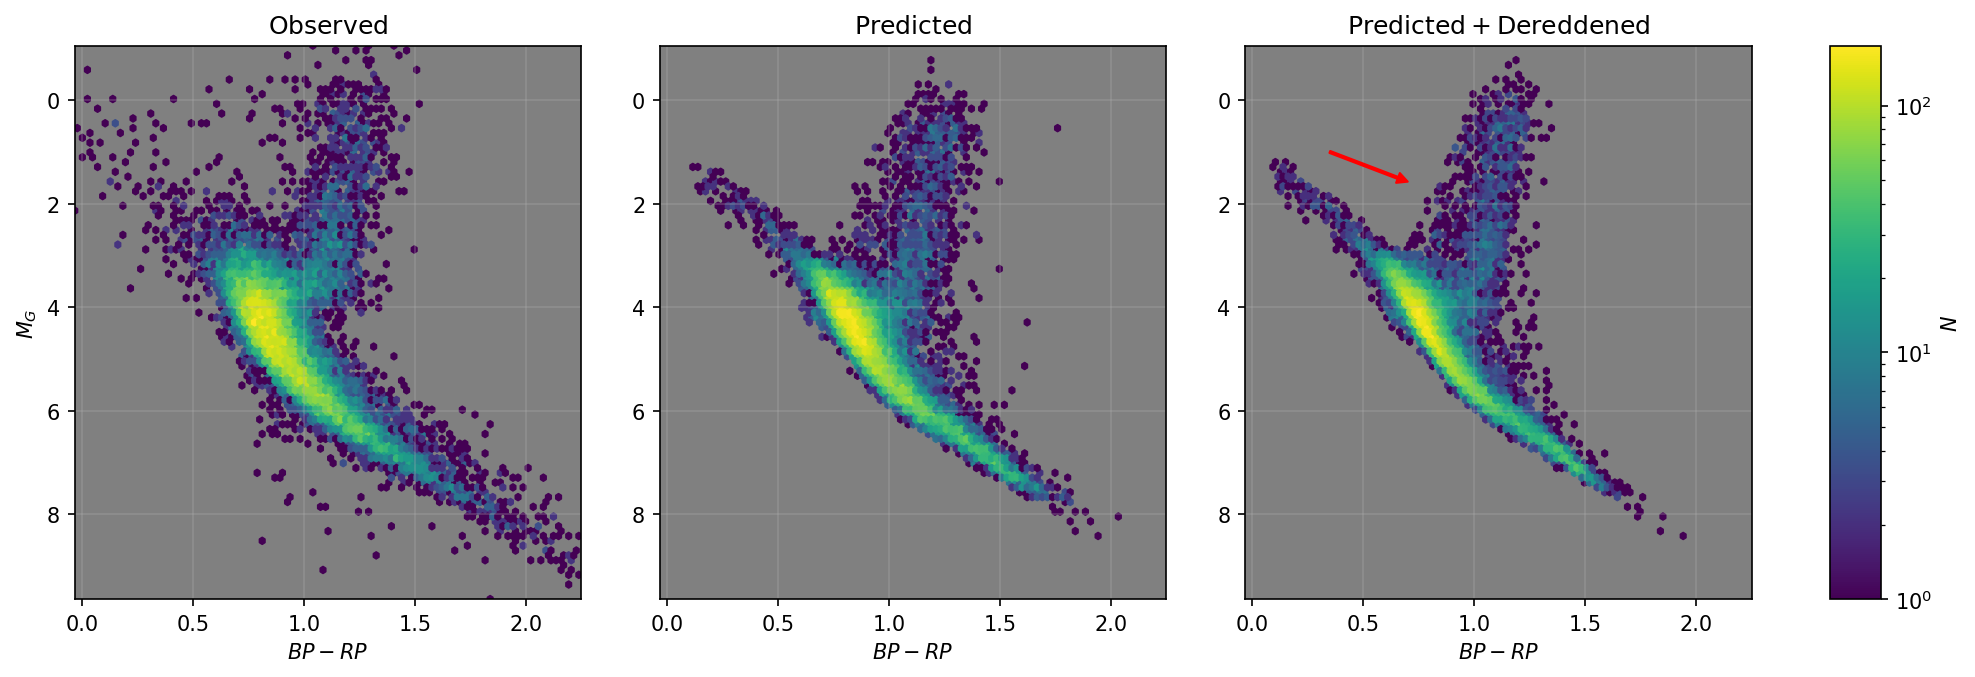

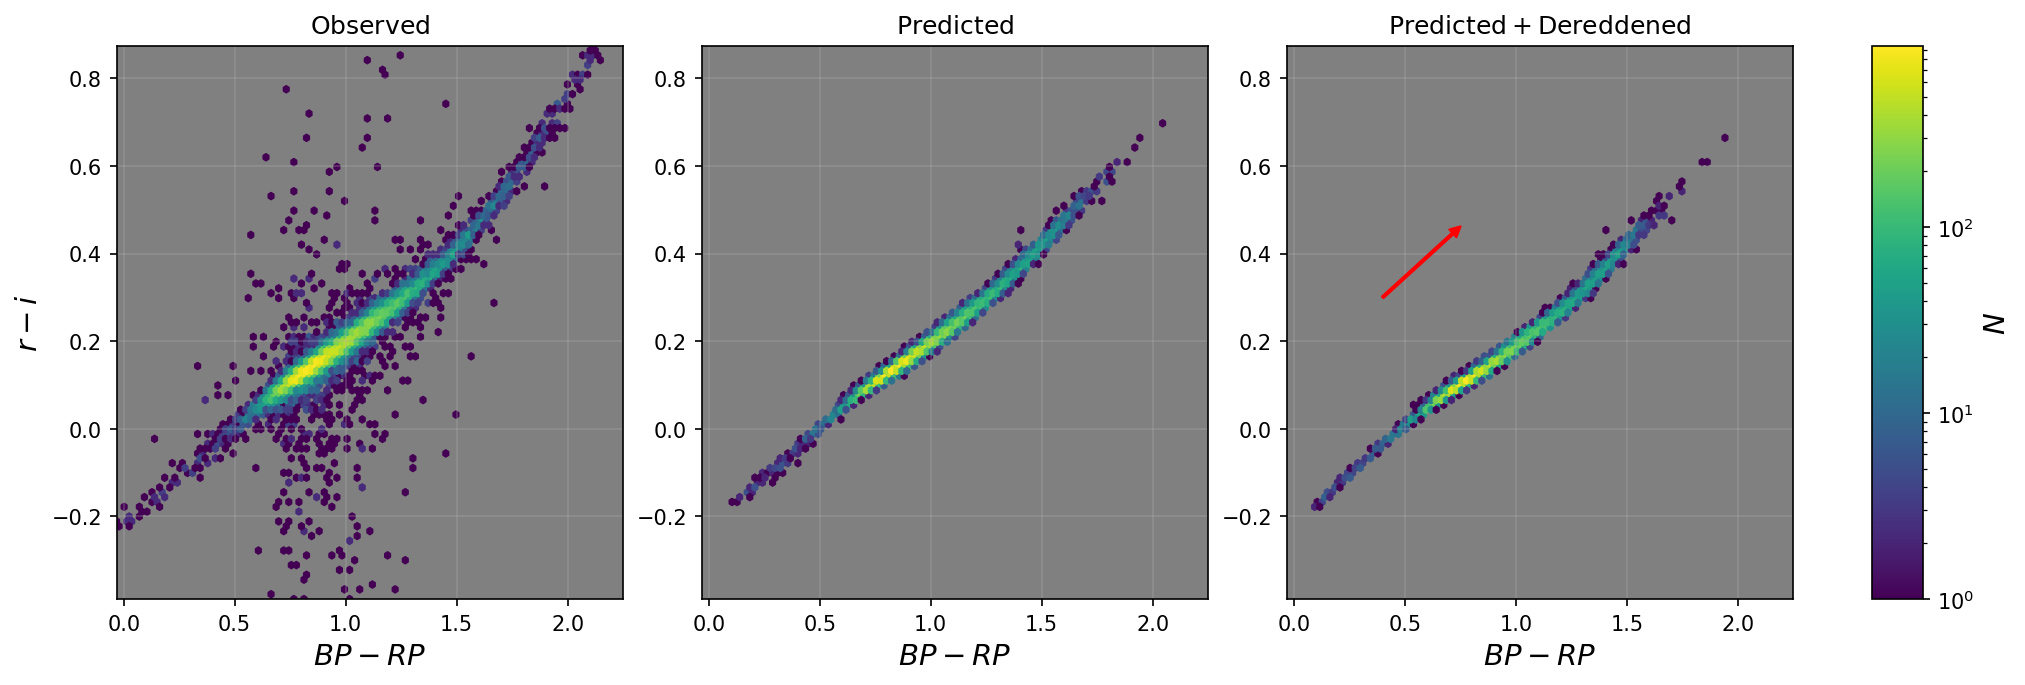

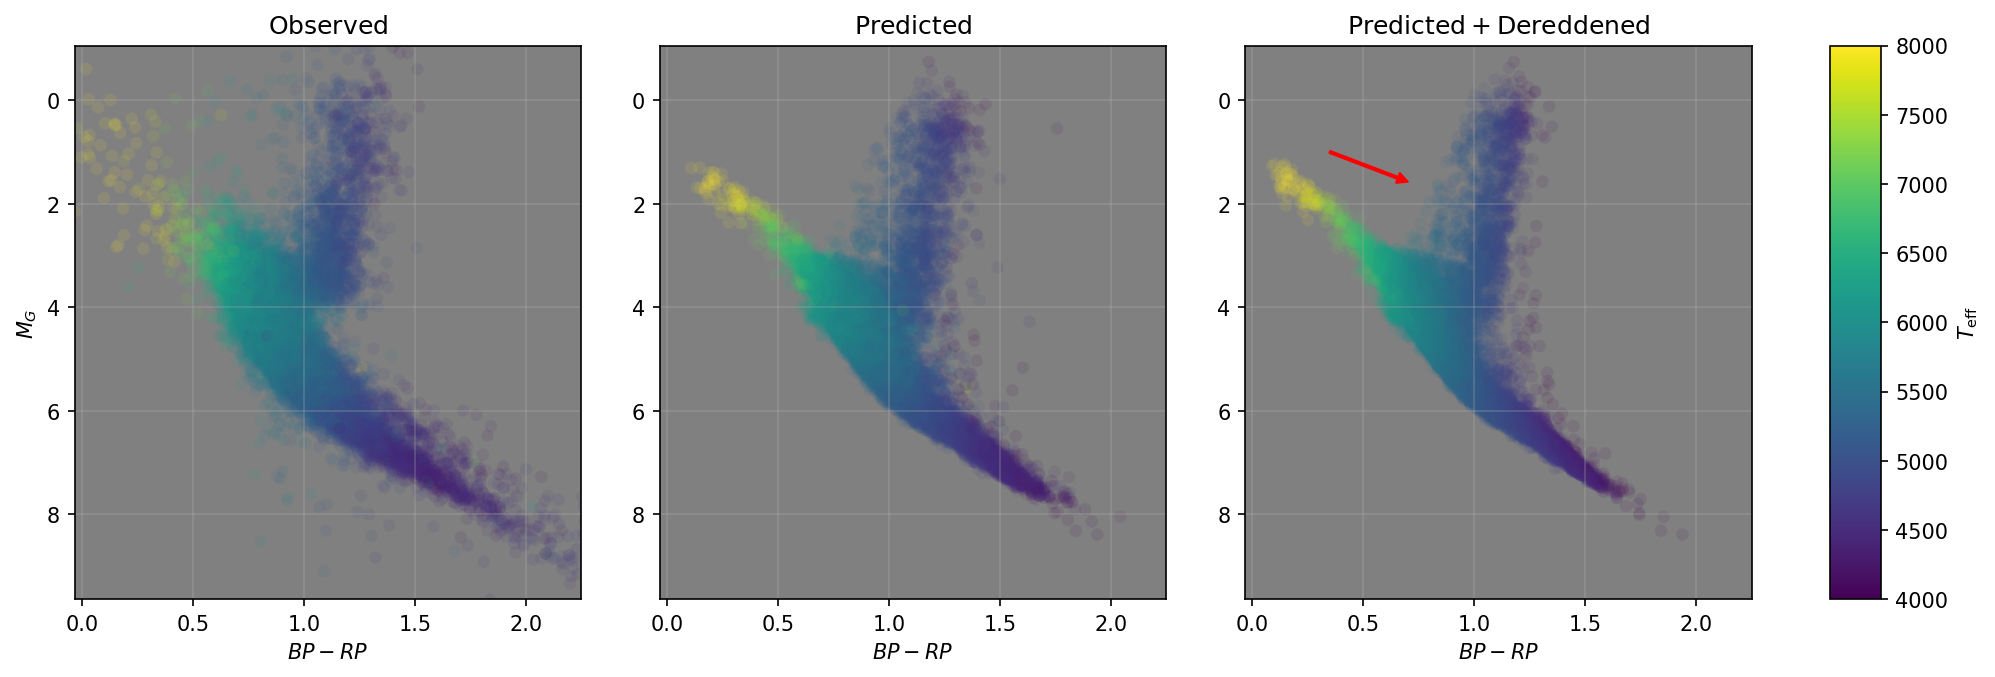

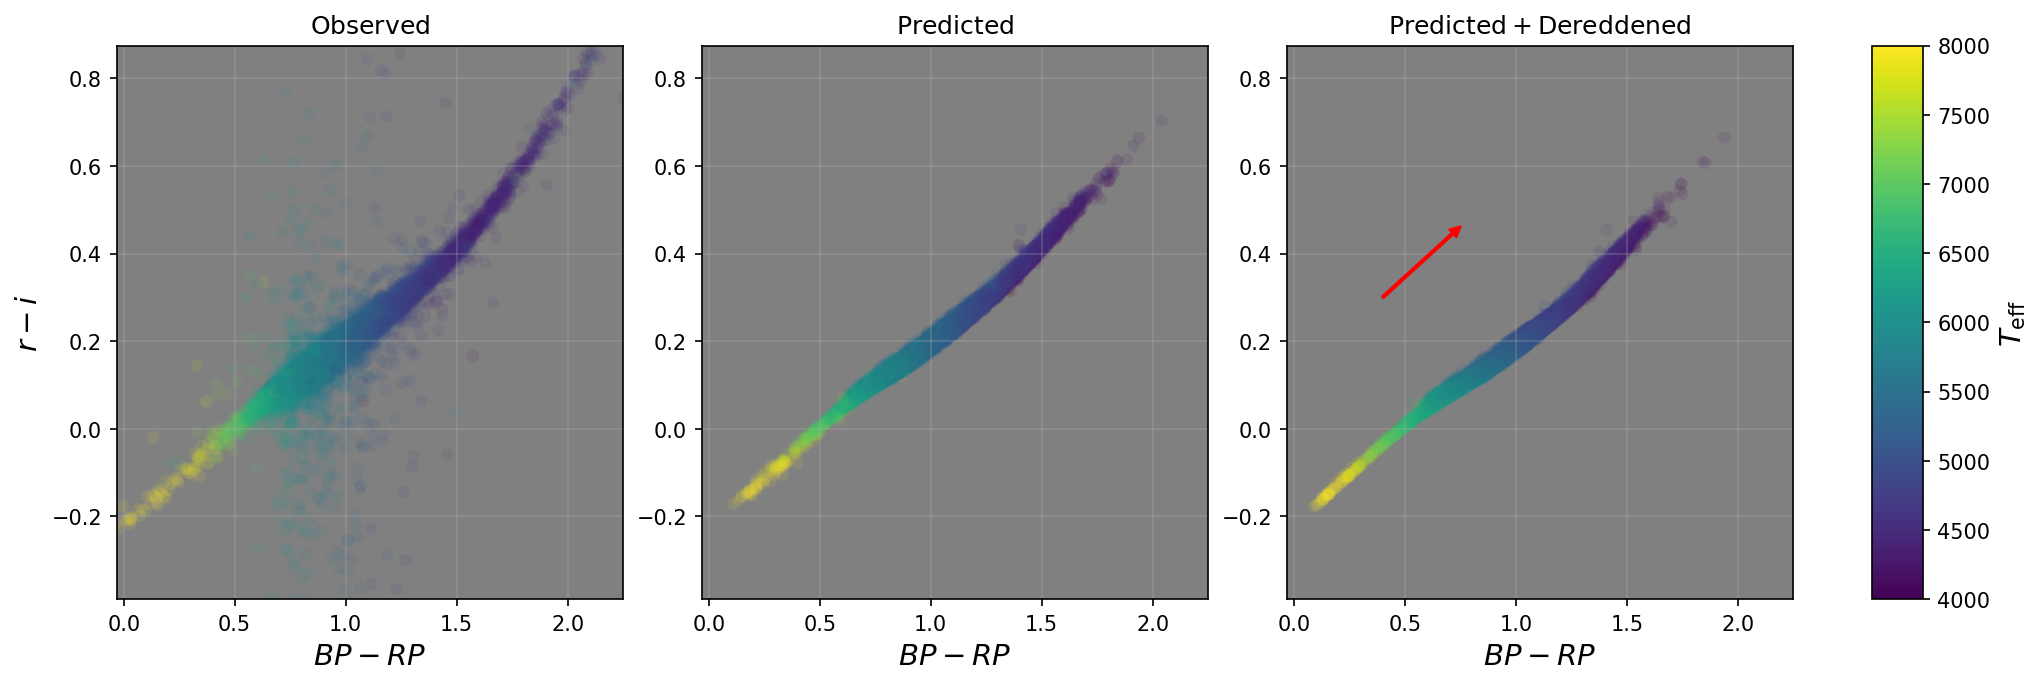

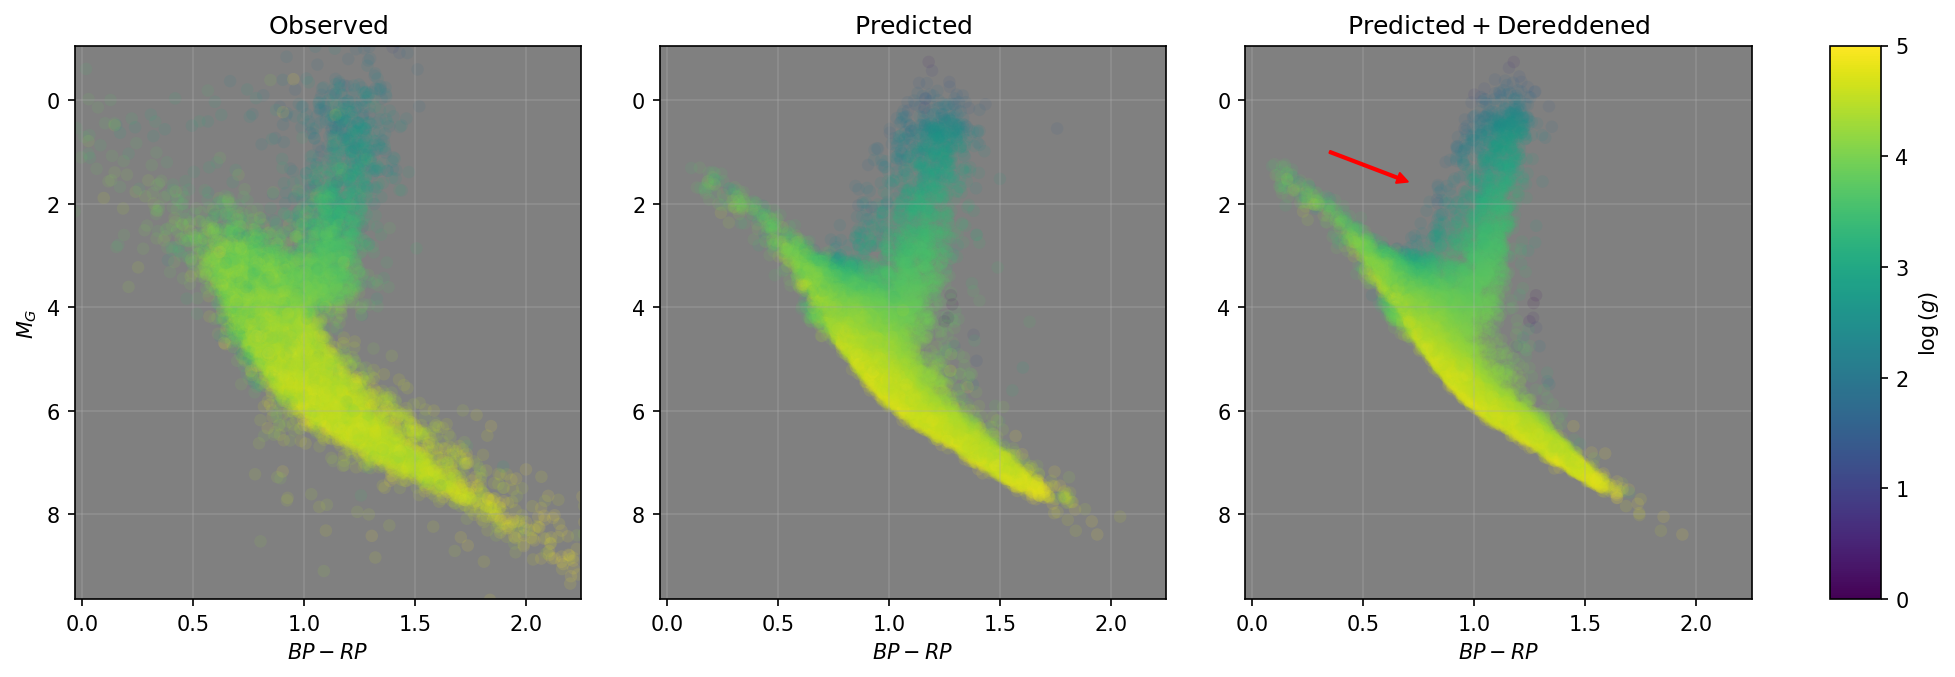

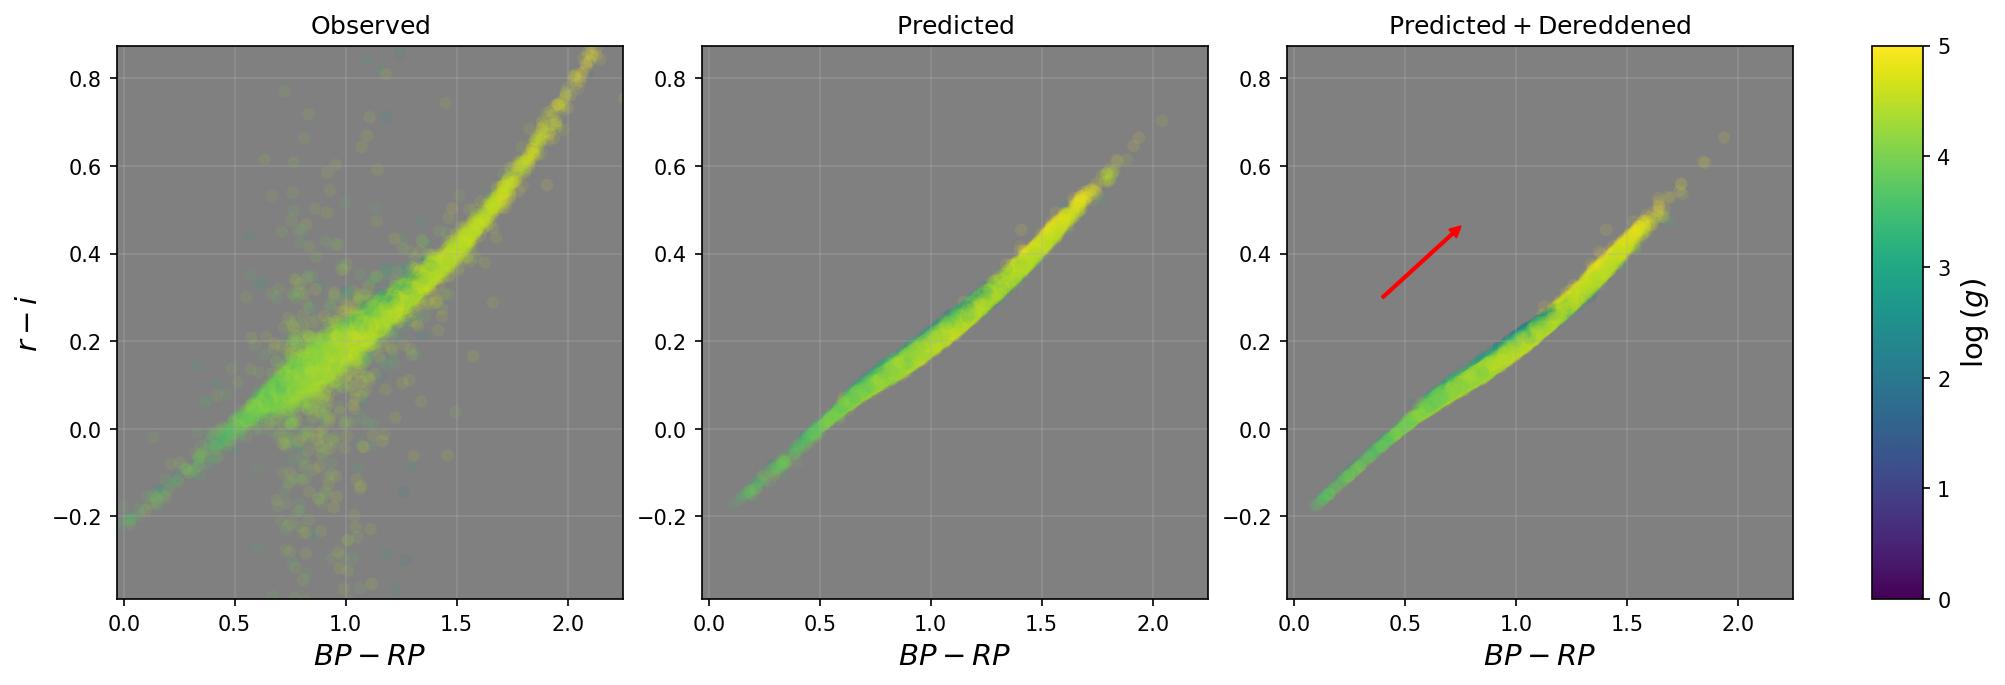

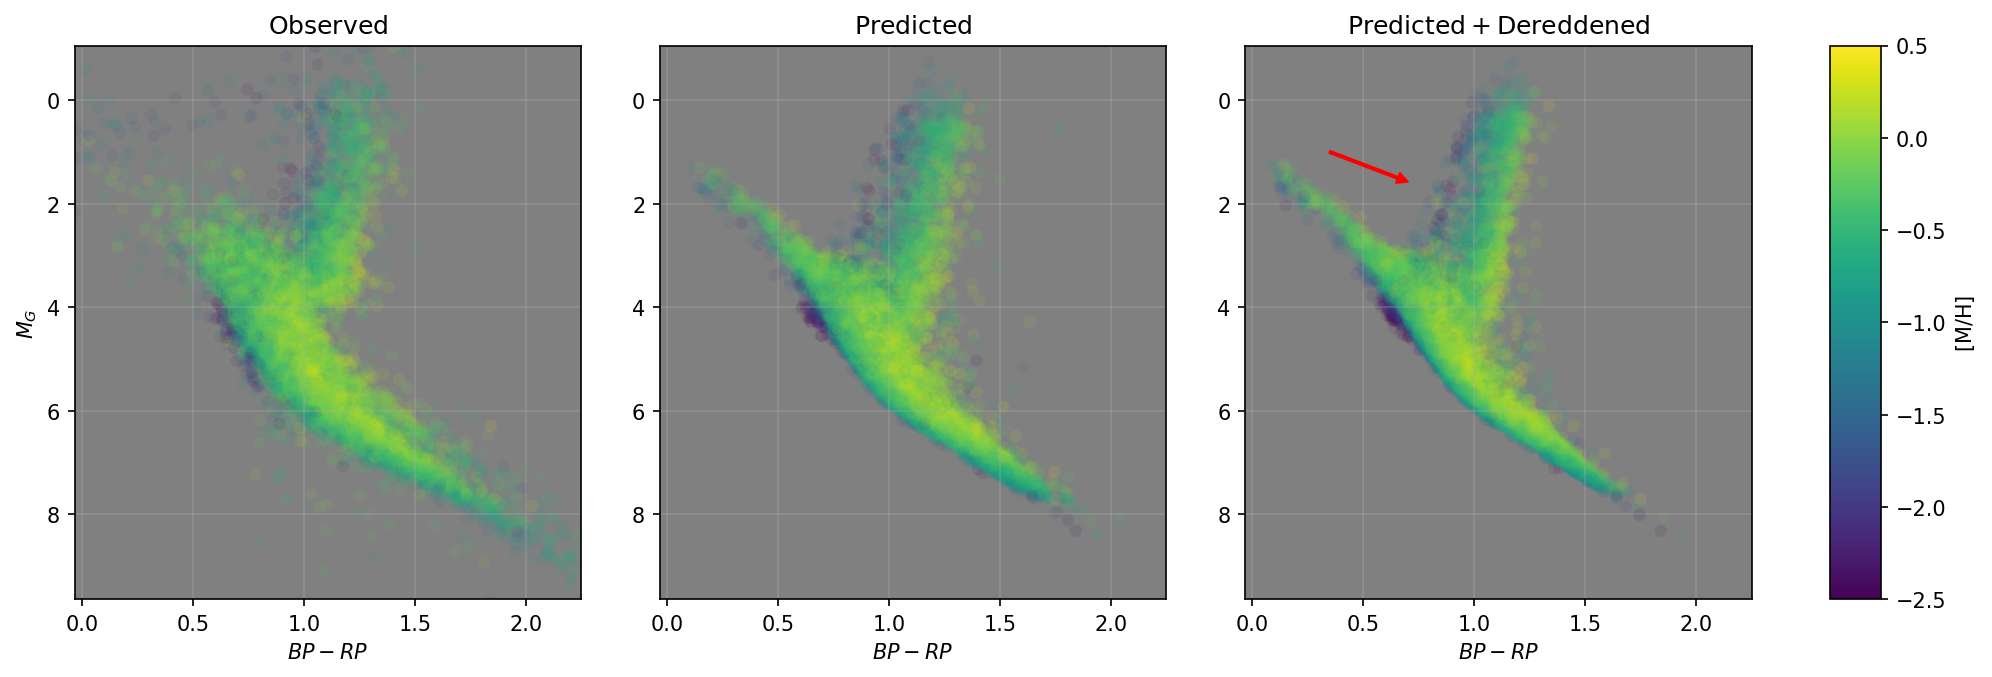

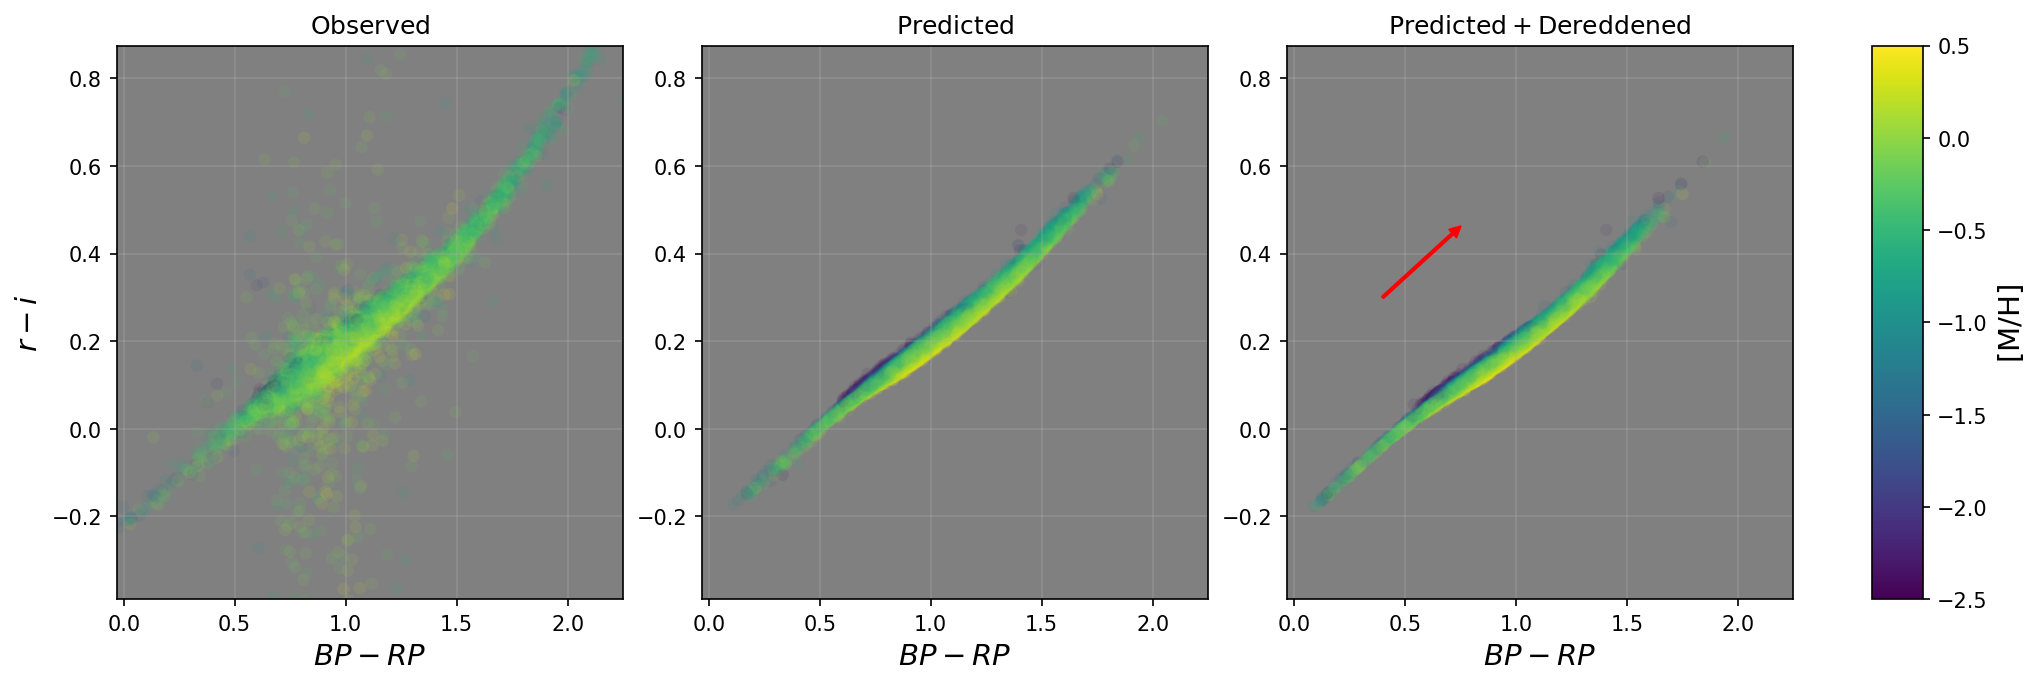

mag_pred: [2.5223286 5.458598  5.6665983 ... 4.1514306 3.8952687 3.19859  ]


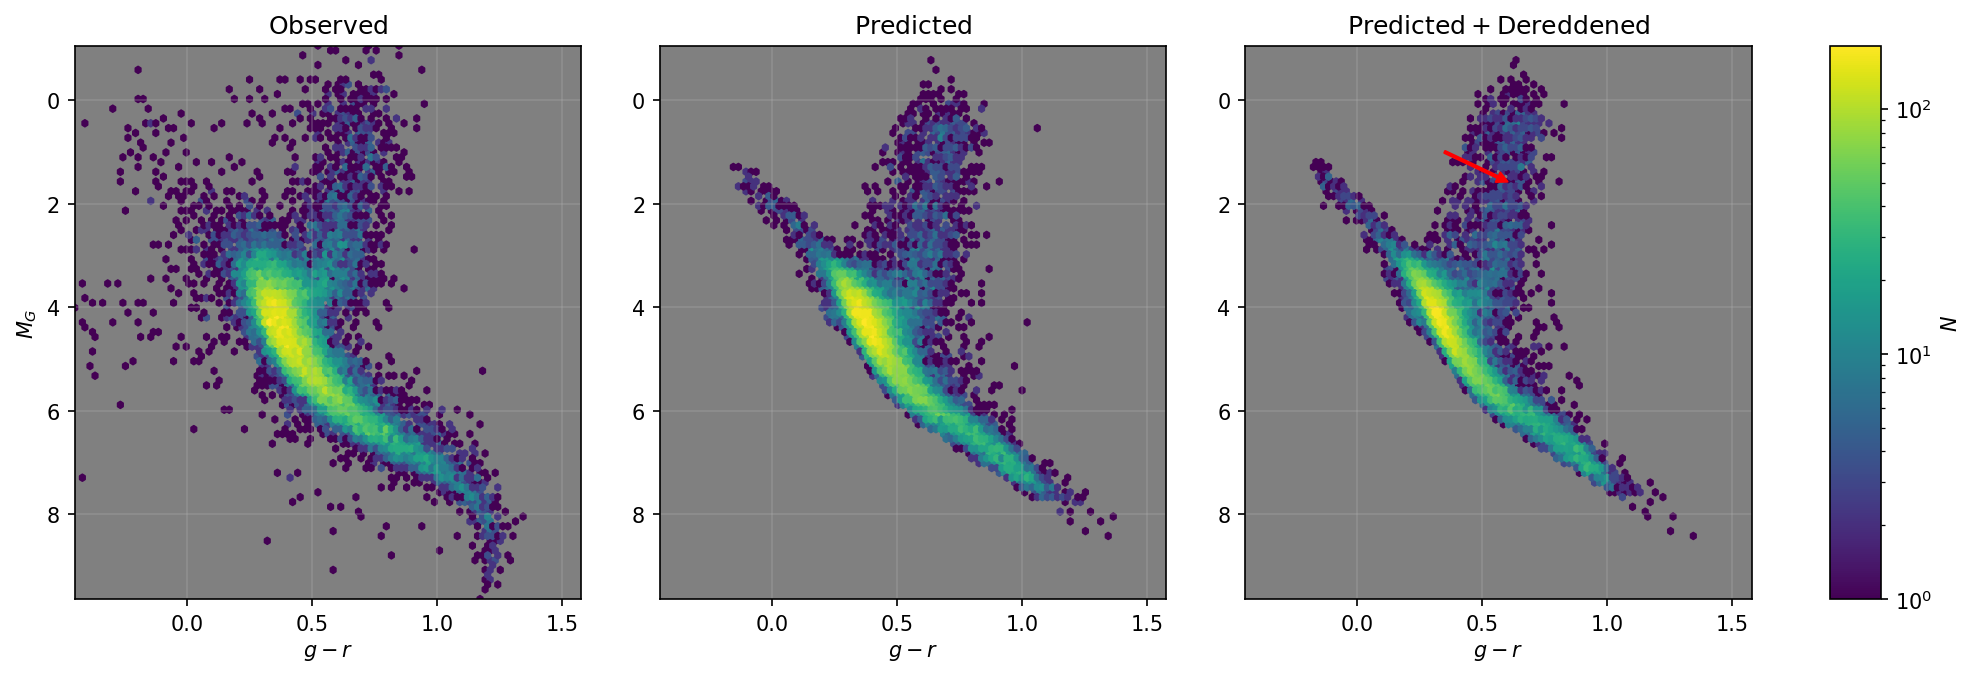

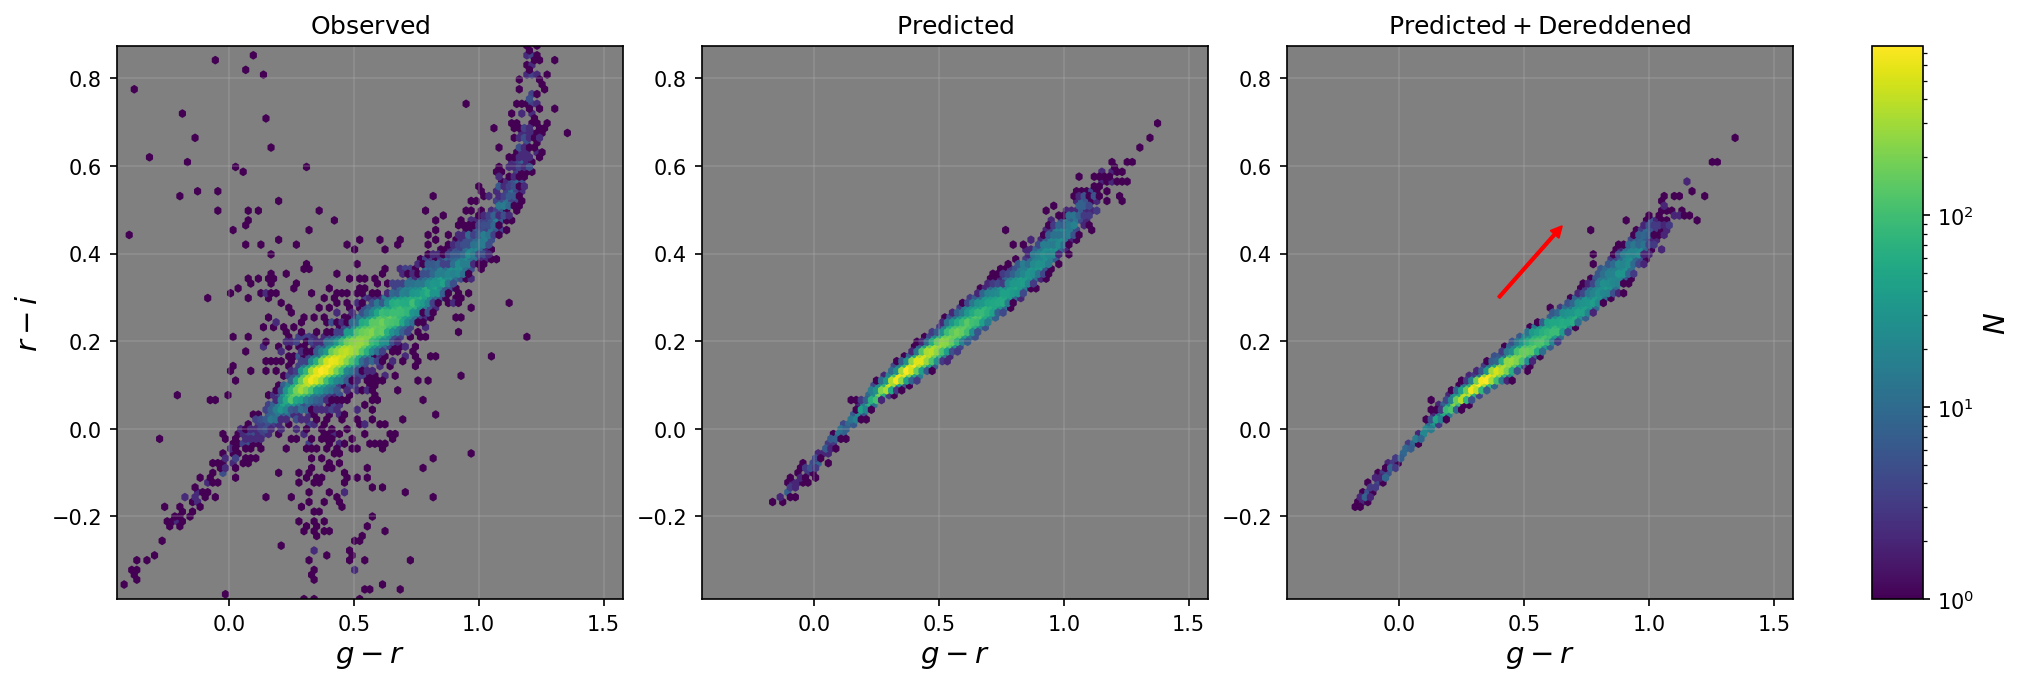

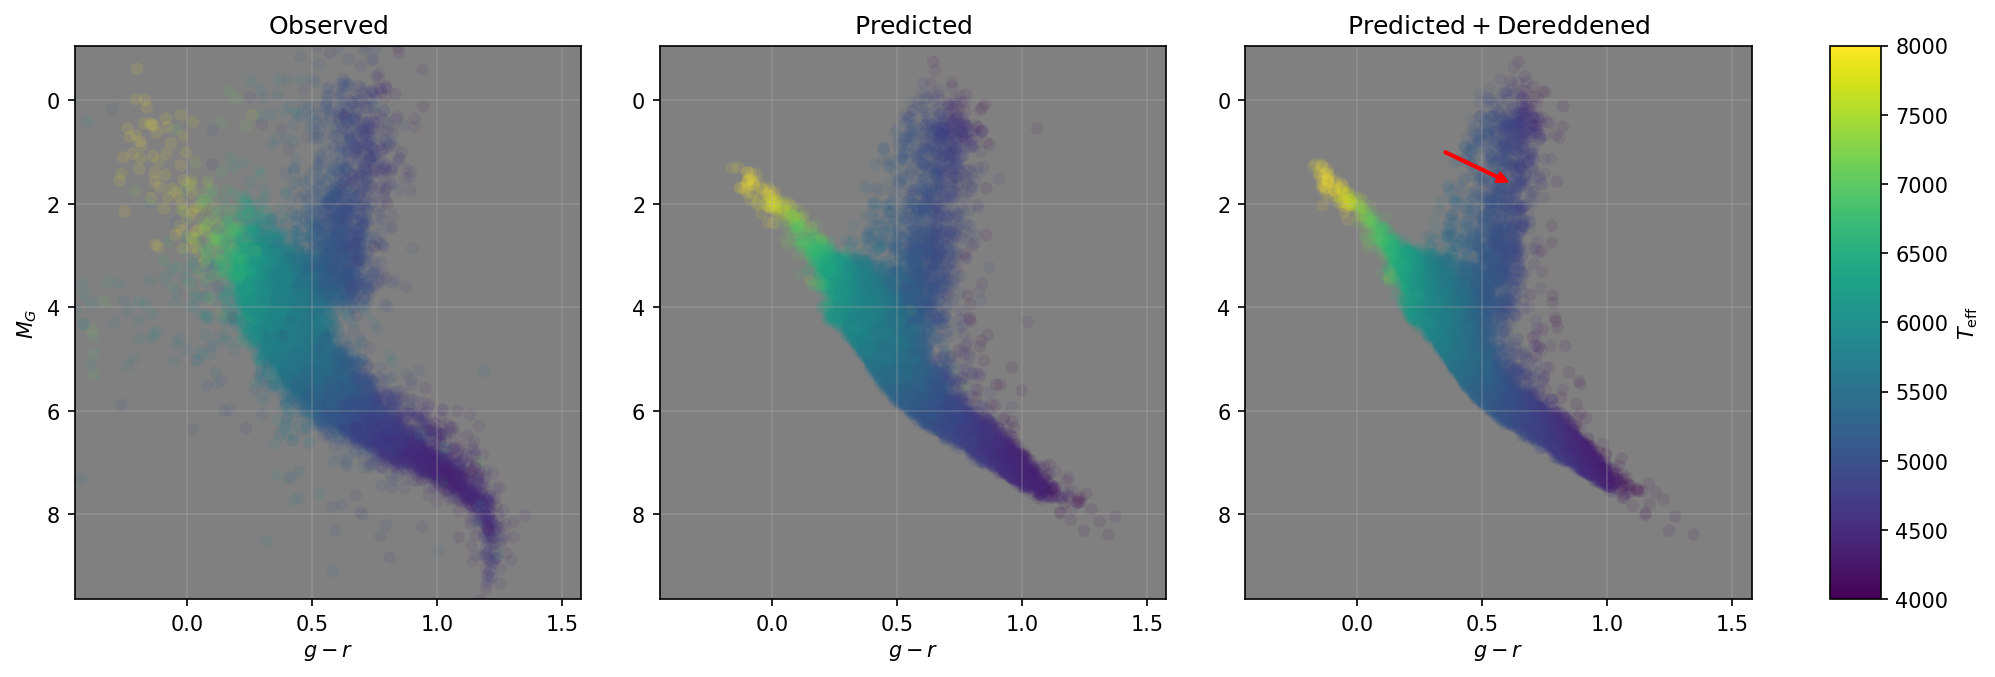

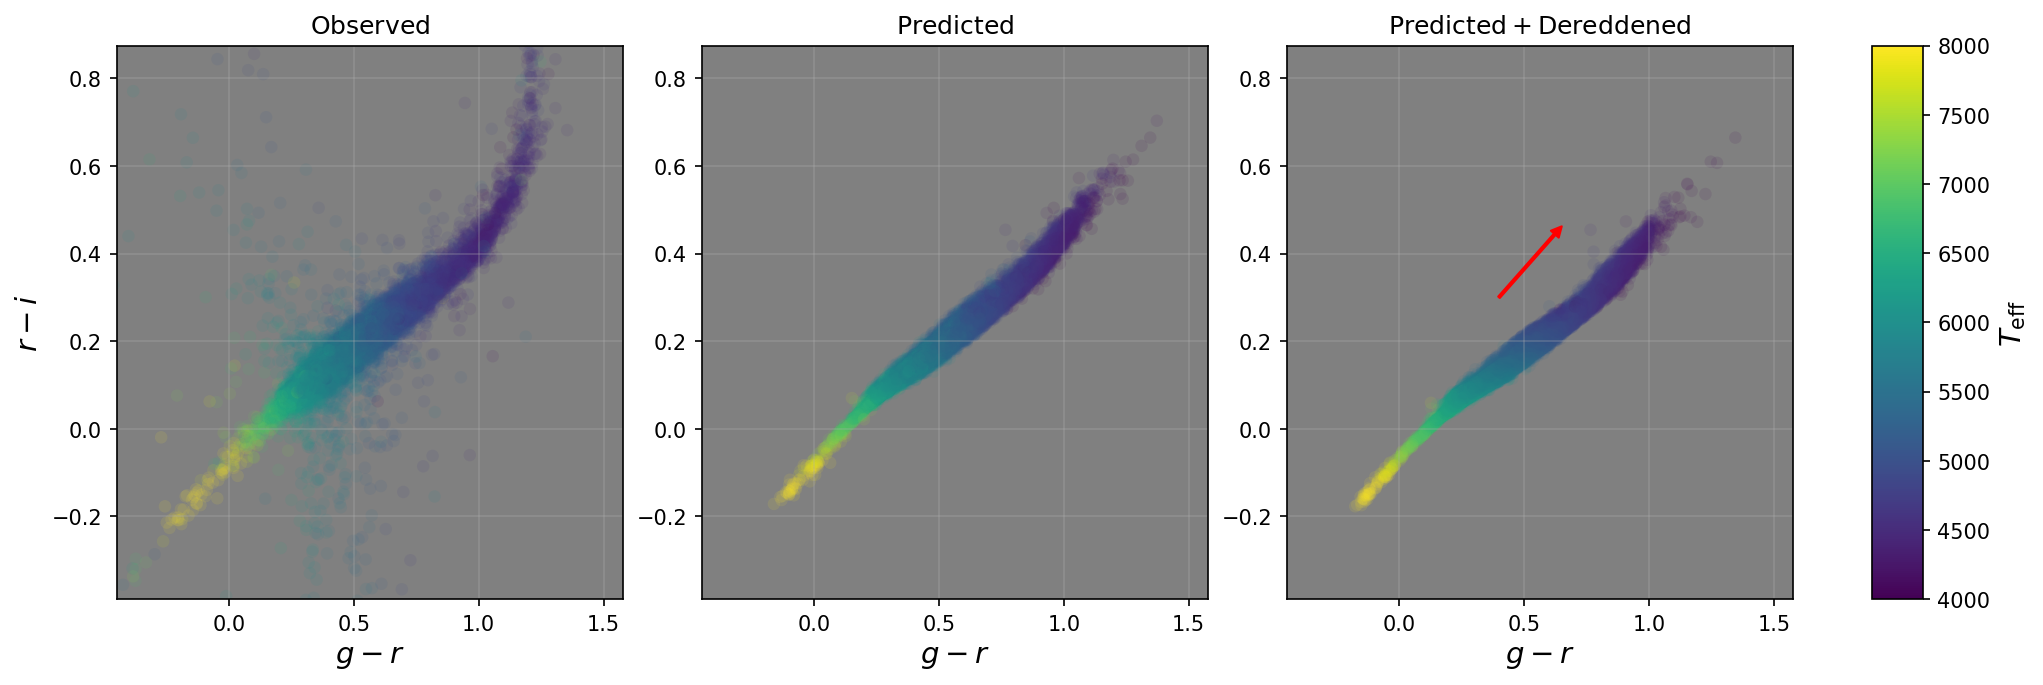

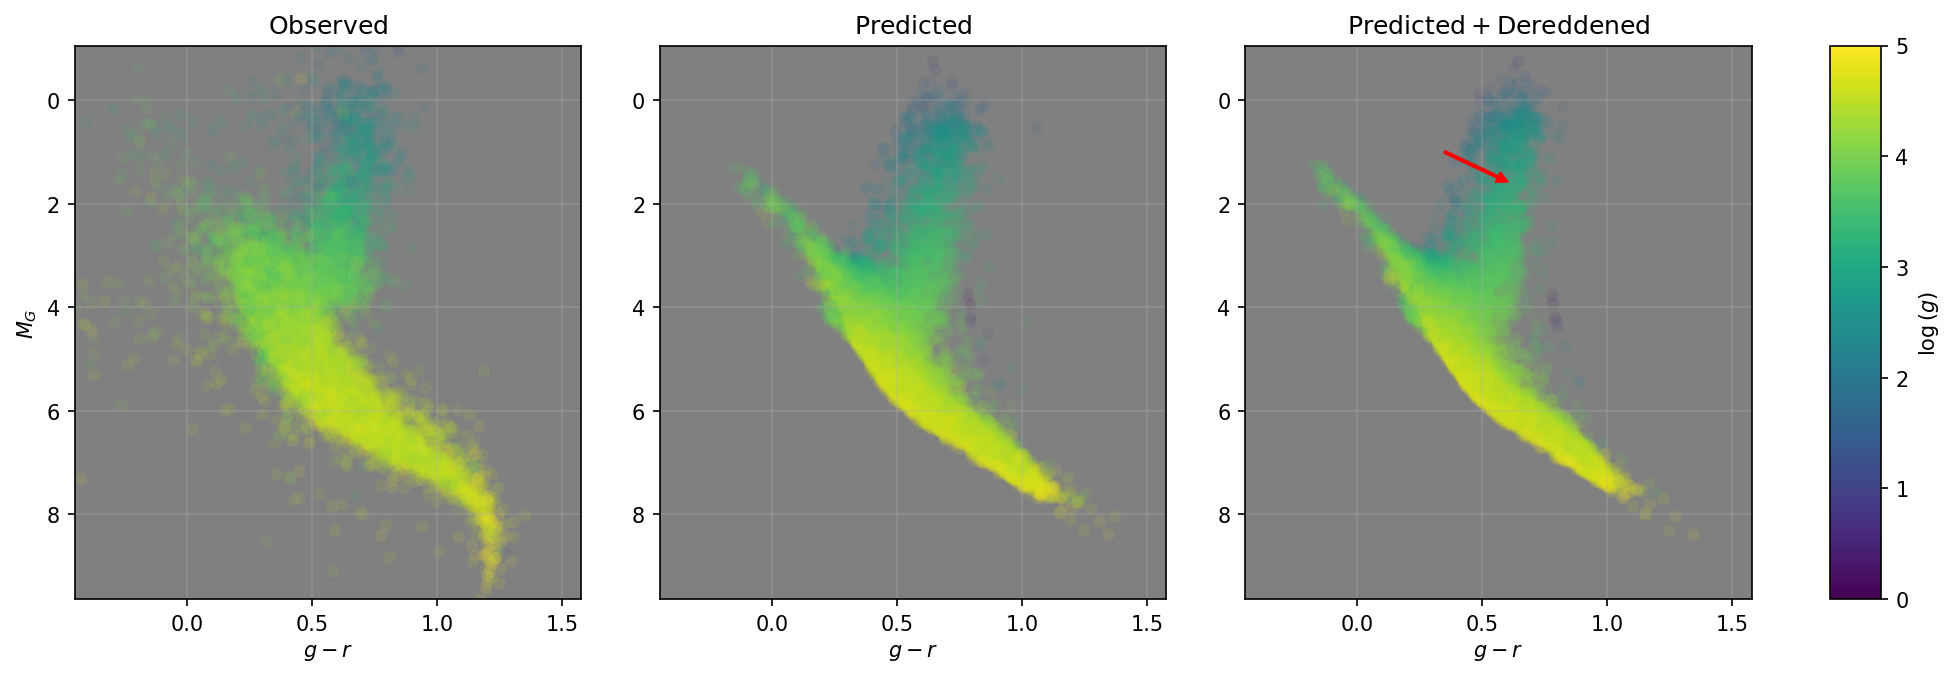

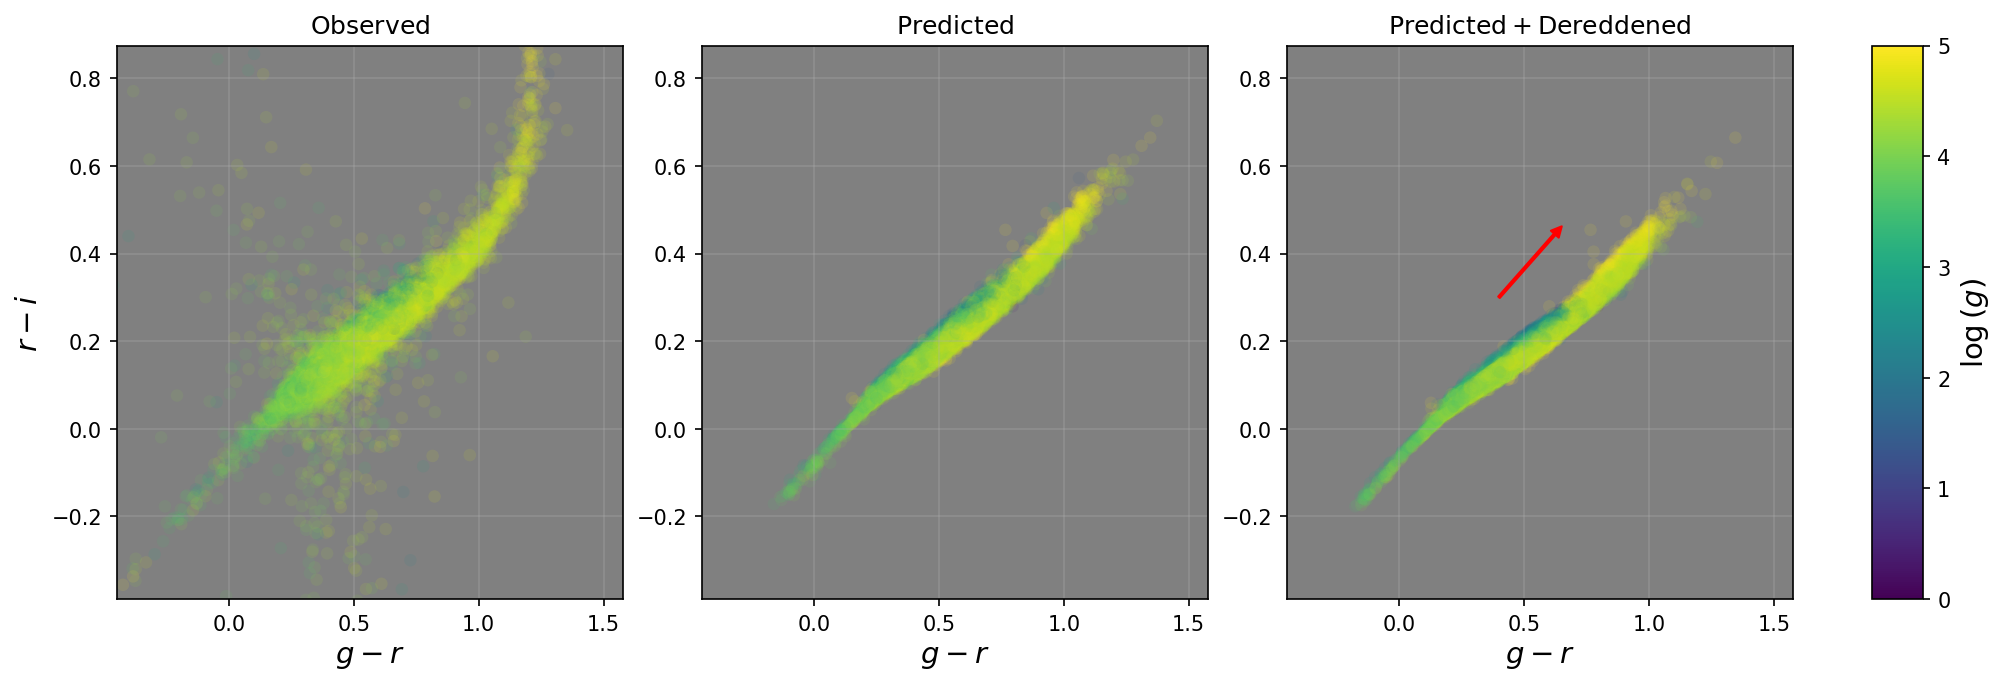

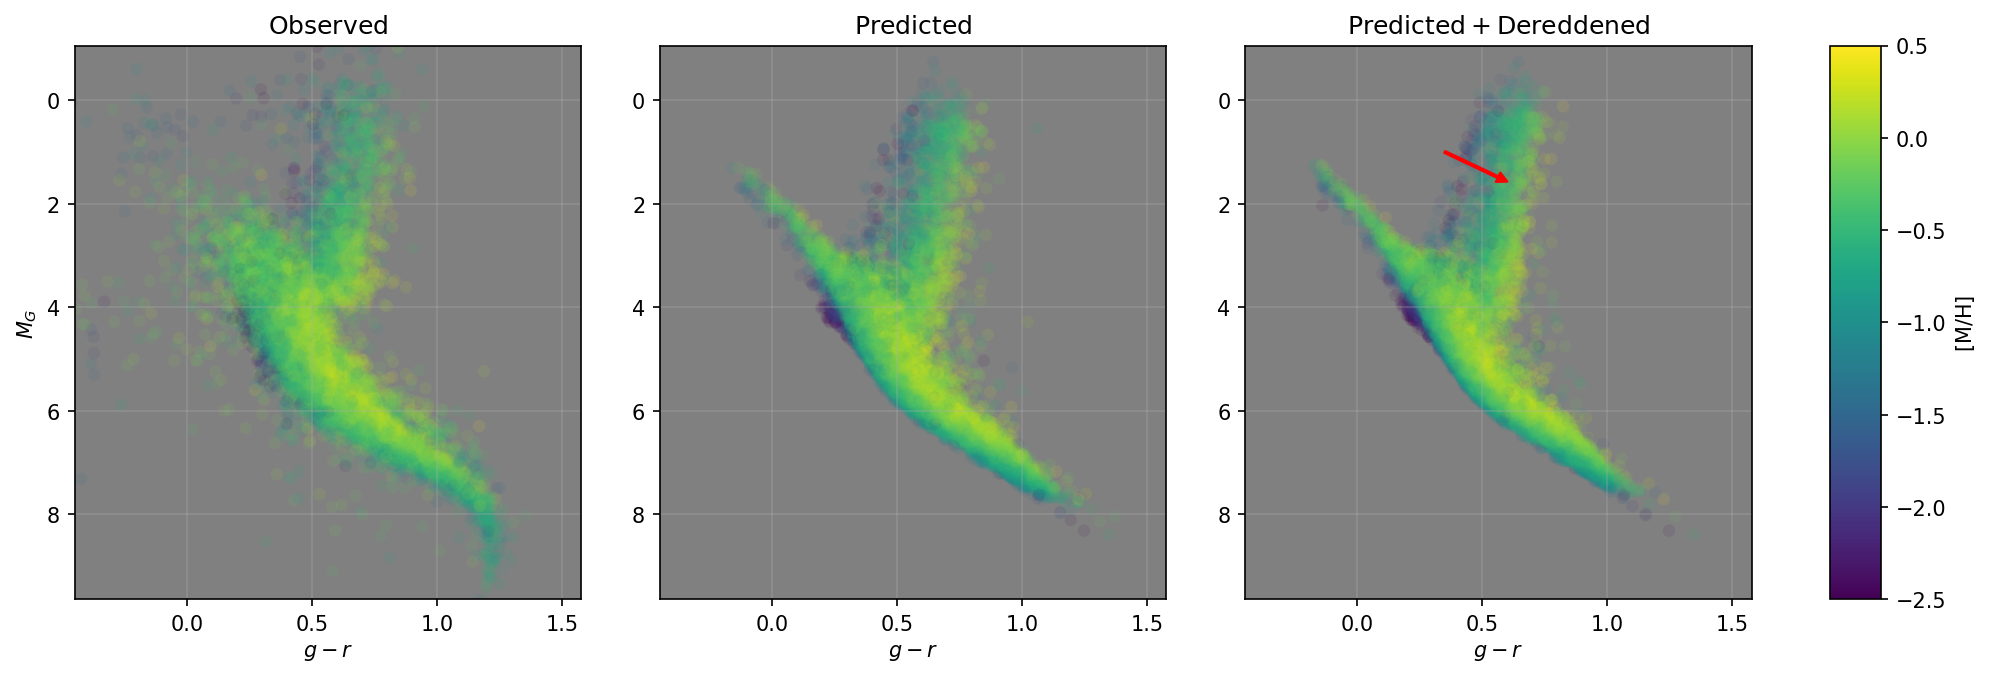

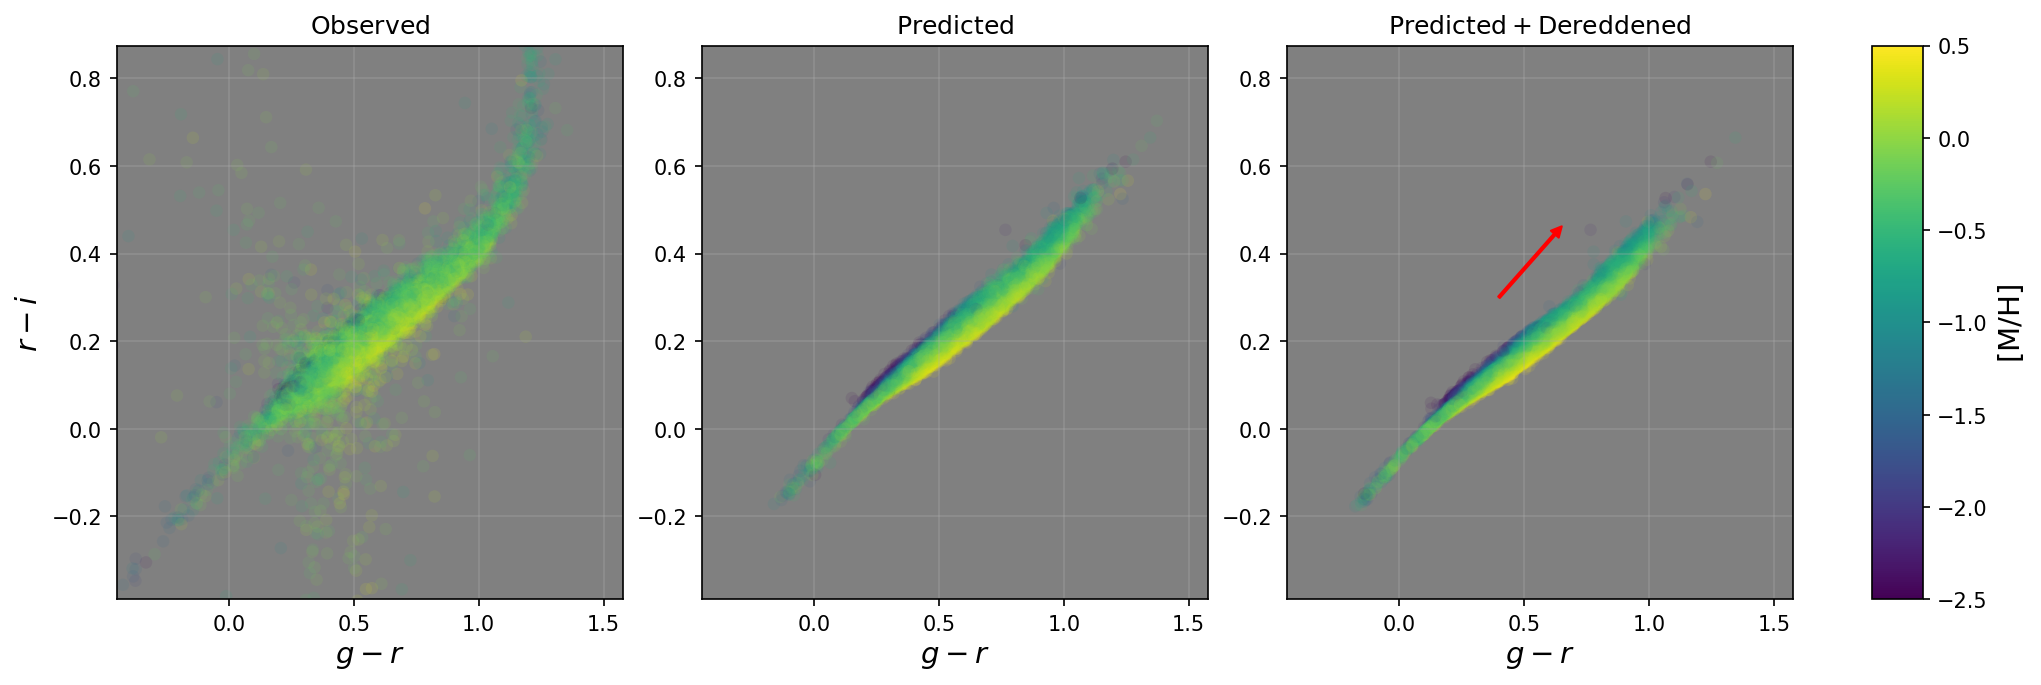

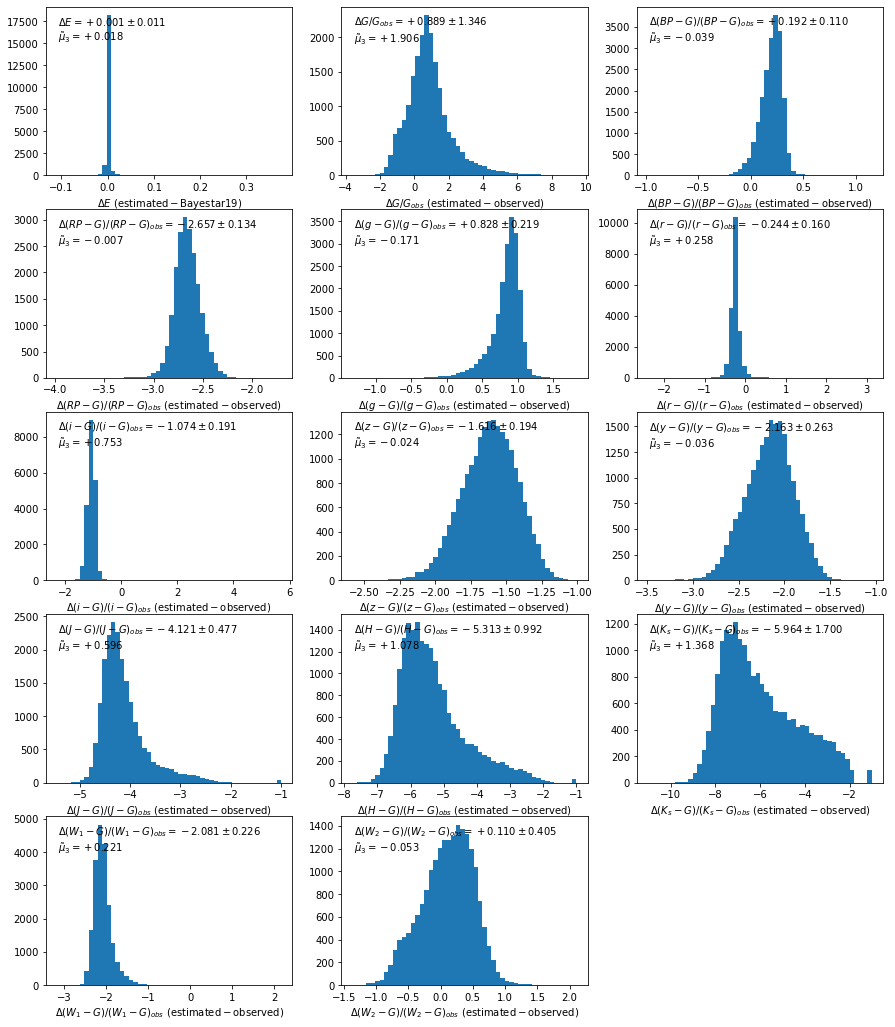

Time elapsed to make plots: 23.80 s


In [17]:
# Plot results on test set
print('Diagnostic plots ...')
t0 = time()
diagnostic_plots(
   nn_model,
   io_test,
   d_test,
   #io_train,
   #d_train,
   suffix='ext_0h_l1n2_2hidden_it19'
)
# semilogy
t1 = time()
print(f'Time elapsed to make plots: {t1-t0:.2f} s')

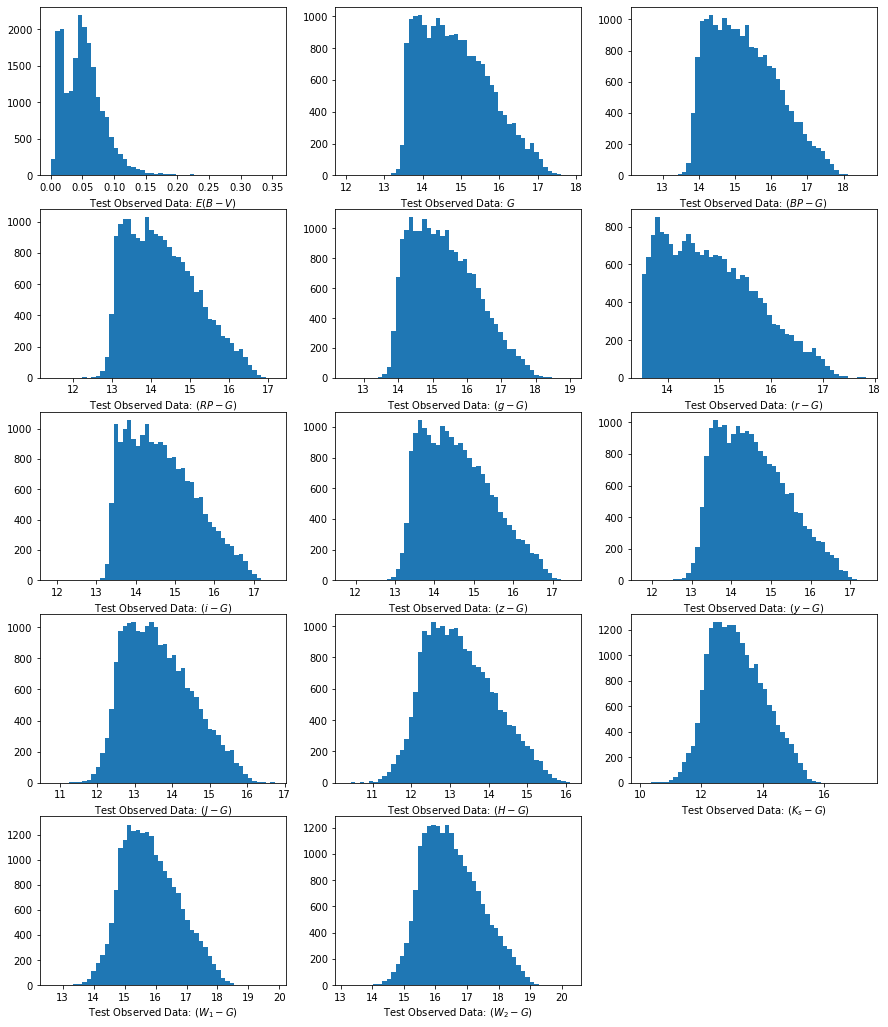

In [18]:
# Plot histograms of original observed params
dr = d_test['r']
names = ['G','(BP-G)','(RP-G)','(g-G)','(r-G)','(i-G)','(z-G)','(y-G)','(J-G)','(H-G)','(K_s-G)','(W_1-G)','(W_2-G)']
fig = plt.figure(figsize=(15,18))
ax = fig.add_subplot(5,3,1)
ax.hist(dr, bins=50)
ax.set_xlabel(r'Test Observed Data: $E(B-V)$',fontsize=10)
# ax.set_xlabel(r'$\Delta E \ \left( \mathrm{estimated} - \mathrm{Bayestar19} \right)$',fontsize=10)
mask = (io_test['LTy'][:,1] > 0) & (io_test['LTy'][:,7] < 0)
for it,(dm,name) in enumerate(zip(d_test['mag'].T,names)):
    dd = dm[mask]
    ax = fig.add_subplot(5,3,it+2)
    ax.hist(dd, bins=50)
    ax.set_xlabel(r'Test Observed Data: $'+name+r'$',fontsize=10)
# plt.savefig('/arc/home/aydanmckay/ml/network/testdataplots.svg')
plt.show()

(array([1.000e+00, 2.000e+00, 2.000e+00, 9.000e+00, 2.000e+01, 4.000e+01,
       7.700e+01, 2.290e+02, 5.380e+02, 6.660e+02, 7.730e+02, 9.150e+02,
       1.293e+03, 1.717e+03, 2.159e+03, 2.409e+03, 2.249e+03, 1.703e+03,
       1.229e+03, 9.140e+02, 6.520e+02, 5.460e+02, 4.570e+02, 3.210e+02,
       2.630e+02, 2.150e+02, 2.000e+02, 1.420e+02, 1.320e+02, 1.040e+02,
       9.300e+01, 6.300e+01, 6.300e+01, 5.000e+01, 4.600e+01, 2.300e+01,
       3.300e+01, 2.100e+01, 1.700e+01, 1.100e+01, 9.000e+00, 8.000e+00,
       4.000e+00, 3.000e+00, 2.000e+00, 4.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 1.000e+00]), array([-36.062584  , -32.14625   , -28.229918  , -24.313585  ,
       -20.397253  , -16.480919  , -12.564587  ,  -8.648254  ,
        -4.731921  ,  -0.81558824,   3.1007447 ,   7.0170774 ,
        10.933411  ,  14.849743  ,  18.766075  ,  22.68241   ,
        26.598742  ,  30.515074  ,  34.431408  ,  38.34774   ,
        42.264072  ,  46.180405  ,  50.09674   ,  54.013073  ,
      

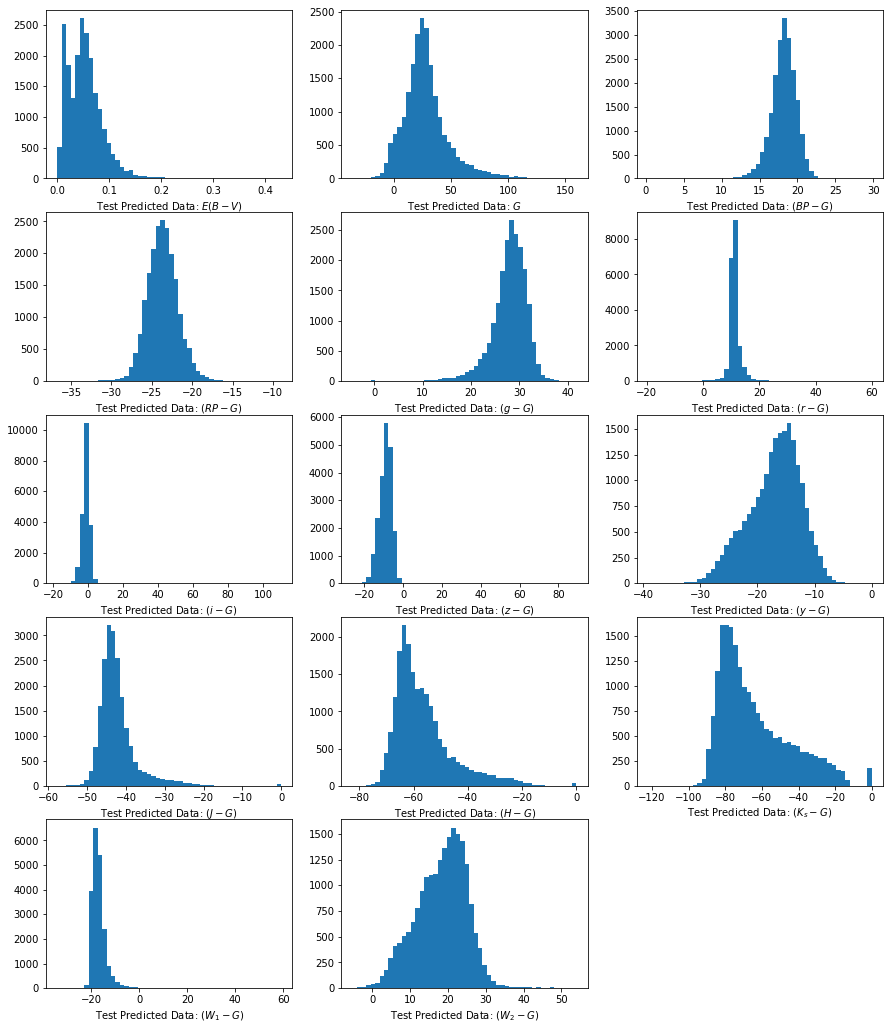

In [19]:
# Plot histograms of original observed params
dr = io_test['r']
names = ['G','(BP-G)','(RP-G)','(g-G)','(r-G)','(i-G)','(z-G)','(y-G)','(J-G)','(H-G)','(K_s-G)','(W_1-G)','(W_2-G)']
fig = plt.figure(figsize=(15,18))
ax = fig.add_subplot(5,3,1)
ax.hist(dr, bins=50)
ax.set_xlabel(r'Test Predicted Data: $E(B-V)$',fontsize=10)
# ax.set_xlabel(r'$\Delta E \ \left( \mathrm{estimated} - \mathrm{Bayestar19} \right)$',fontsize=10)
mask = (io_test['LTy'][:,1] > 0) & (io_test['LTy'][:,7] < 0)
for it,(dm,name) in enumerate(zip(io_test['LTy'].T,names)):
    dd = dm[mask]
    ax = fig.add_subplot(5,3,it+2)
    histy = ax.hist(dd, bins=50)
    print(histy)
    ax.set_xlabel(r'Test Predicted Data: $'+name+r'$',fontsize=10)
# plt.savefig('/arc/home/aydanmckay/ml/network/testdatapredplots.svg')
plt.show()

In [20]:
mask = (io_test['LTy'][:,1] > 0) & (io_test['LTy'][:,7] < 0) & (io_test['LTy'][:,6] < 0)
# mask2 = d_test['mag'][:,4] > 13.500888

(array([1.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 1.000e+00,
        6.000e+00, 4.000e+00, 7.000e+00, 4.000e+00, 1.200e+01, 1.200e+01,
        6.000e+00, 2.100e+01, 3.800e+01, 7.700e+01, 1.030e+02, 1.940e+02,
        3.050e+02, 5.510e+02, 8.690e+02, 1.373e+03, 2.156e+03, 2.889e+03,
        3.360e+03, 2.939e+03, 2.265e+03, 1.631e+03, 9.220e+02, 4.010e+02,
        1.600e+02, 4.100e+01, 1.700e+01, 1.200e+01, 6.000e+00, 4.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00]),
 array([ 0.2745037,  0.8655162,  1.4565287,  2.0475411,  2.6385536,
         3.229566 ,  3.8205786,  4.411591 ,  5.0026035,  5.593616 ,
         6.1846285,  6.775641 ,  7.3666534,  7.9576664,  8.548678 ,
         9.139691 ,  9.730703 , 10.321716 , 10.912728 , 11.503741 ,
        12.094753 , 12.685766 , 13.276778 , 13.867791 , 14.458803 ,
        15.049816 , 15.640829 , 16.2

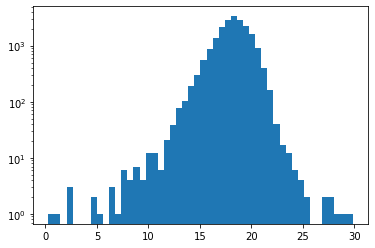

In [21]:
plt.hist(io_test['LTy'][:,1][mask],bins=50,log=True)

(array([553., 640., 758., 851., 778., 762., 710., 652., 670., 724., 762.,
        716., 671., 652., 682., 641., 651., 646., 627., 563., 583., 524.,
        544., 535., 460., 458., 424., 398., 332., 284., 279., 261., 234.,
        228., 198., 195., 136., 138., 157., 114., 100.,  64.,  40.,  24.,
         12.,  11.,   1.,   0.,   2.,   2.]),
 array([13.5009  , 13.587404, 13.673908, 13.760412, 13.846916, 13.93342 ,
        14.019924, 14.106428, 14.192932, 14.279436, 14.36594 , 14.452444,
        14.538948, 14.625452, 14.711956, 14.79846 , 14.884964, 14.971468,
        15.057972, 15.144476, 15.23098 , 15.317484, 15.403988, 15.490492,
        15.576996, 15.6635  , 15.750004, 15.836508, 15.923012, 16.009516,
        16.09602 , 16.182524, 16.269028, 16.355532, 16.442036, 16.52854 ,
        16.615044, 16.701548, 16.788052, 16.874556, 16.96106 , 17.047564,
        17.134068, 17.220572, 17.307076, 17.39358 , 17.480083, 17.566587,
        17.653091, 17.739595, 17.8261  ], dtype=float32),
 <BarCon

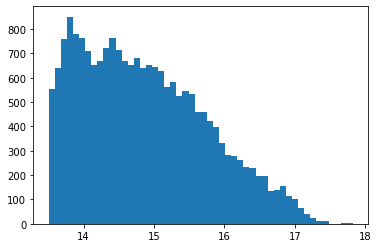

In [22]:
plt.hist(d_test['mag'][:,4],bins=50)